# Code to Solve the Compressed-Sensing Magnetic Resonance Imaging (CS-MRI) Reconstruction Problem

## Problem formulation

$\boldsymbol{y} = \boldsymbol{M} \odot (\boldsymbol{F} \boldsymbol{X} \boldsymbol{F} + \boldsymbol{\varepsilon}) , \hspace{2ex} \boldsymbol{\varepsilon} \sim \mathcal{N} (0, \sigma^2 \boldsymbol{I}), \hspace{2ex} \sigma \geq 0.$

- $\boldsymbol{X} \in \mathbb{R}^{n \times n}$: unknown image to recover 
- $\boldsymbol{F} \in \mathbb{C}^{n \times n}$: DFT matrix (https://en.wikipedia.org/wiki/DFT_matrix) 
- $\boldsymbol{M} \in \{0 ,1\}^{n \times n}$: 0-1 mask that denotes which Fourier coefficients are observed 
- $\boldsymbol{\varepsilon} \in \mathbb{R}^{m}$: noise
- $ \sigma \in \mathbb{R}^+$: noise level 
- $ \boldsymbol{y} \in \mathbb{C}^{m}$: observed measurements (Fourier coefficients) 
- $ \odot : \mathbb{C}^{n_1 \times n_2} \times \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_1 \times n_2}$: denotes the Kronecker product (https://en.wikipedia.org/wiki/Kronecker_product)


## Loss function, gradients

### Loss function:

$\ell ({\boldsymbol{X}}) = \frac{1}{2m} \| \boldsymbol{M} \odot (\boldsymbol{y} - \boldsymbol{F} \boldsymbol{X} \boldsymbol{F}) \|_2^2$

### Loss function as a finite sum:

$\ell (\boldsymbol{X}) := \frac{1}{m} \sum_{\{ i, j | y_{i, j} \not= 0 \}} \ell_{i,j}(\boldsymbol{X}) = \frac{1}{m}\sum_{\{ i, j | y_{i, j} \not= 0 \}} \frac{1}{2}(y_i - \boldsymbol{f}_i^\top \boldsymbol{X} \boldsymbol{f}_j)^2$

- $\boldsymbol{f}_i \in \mathbb{C}^m$: the $i^{\text{th}}$ column of the DFT matrix $\boldsymbol{F}$.


### Full gradient:

$\nabla \ell ({\boldsymbol{X}}) = \frac{1}{m}\boldsymbol{F}^\dagger \boldsymbol{M} \odot(\boldsymbol{y} - \boldsymbol{F} \boldsymbol{X} \boldsymbol{F} ) \boldsymbol{F}^\dagger$

### Stochastic gradient:

$\nabla \ell_{i,j}({\boldsymbol{X}}) = (y_i - \boldsymbol{f}_j^\dagger \boldsymbol{X}^\dagger \boldsymbol{f}_i^\ast) \boldsymbol{f}_j^\dagger\boldsymbol{f}^\ast $

- $\dagger : \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_2 \times n_1} $: Hermitian transpose
- $\ast : \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_1 \times n_2} $: Complex conjugate

In [1]:
from ipynb.fs.full.csmri_gradients import full_grad, stoch_grad, get_batch

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import dirname, abspath
import os
import matplotlib.pyplot as plt
from PIL import Image
import time

from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

In [4]:
np.random.seed(5)

## Set paths
data_path="../data/Set12/"
save_path="./figures/"
image_list = sorted(os.listdir(data_path))

## Read test image
# normalize image pixels in range [0,1]
# orig = np.array(Image.open(data_path + image_list[8])) / 225.0
ORIG = Image.open(data_path + image_list[12]).resize((256,256))
ORIG = np.array(ORIG) / 255.0
mintmp = np.min(ORIG)
maxtmp = np.max(ORIG)
ORIG = (ORIG - mintmp) / (maxtmp - mintmp)

(-0.5, 255.5, 255.5, -0.5)

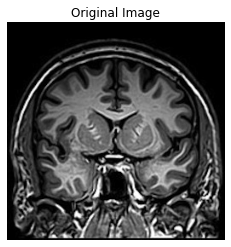

In [5]:
## Display original image
orig_fig = plt.figure()
ax = orig_fig.add_subplot(1, 1, 1)
orig_plot = plt.imshow(ORIG, cmap='gray', vmin=0, vmax=1)
ax.set_title('Original Image')
ax.axis('off')

In [6]:
## Set signal model parameters
prob = .5 							# percentage of Fourier coefficients measured
H, W = ORIG.shape[:2] 				# height and width of orig image
N = H*W 							# image dimension
sigma = 1							# noise level of measurements

## Make measurements
mask = np.random.choice([0, 1], size=(H,W), p=[1 - prob, prob])	# generate random mask

index = np.nonzero(mask)
index = np.transpose(index)

noises = np.random.normal(0, sigma, (H,W))						# generate random noise
forig = np.fft.fft2(ORIG) 										# fft2 of image
forig_n = forig + noises
y = np.multiply(forig_n, mask)									# measurements

## Initialize variables
x_init = np.abs(np.fft.ifft2(y))
mintmp = np.min(x_init)
maxtmp = np.max(x_init)
x_init = (x_init - mintmp) / (maxtmp - mintmp)
x = np.copy(x_init)

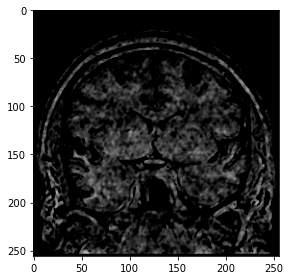

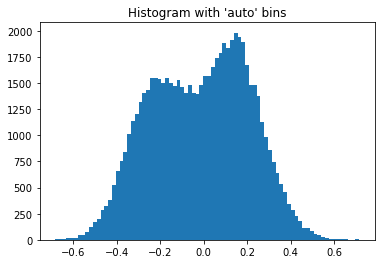

-0.016301230278464487 0.2234851359398709


In [7]:
x_diff = ORIG - x_init

## Display inverse 2D-DFT of observed Fourier coefficients

fig, axs = plt.subplots(1, 1, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs = plt.imshow(x_diff, cmap='gray', vmin=0, vmax=1)
plt.show()

x_diff = np.matrix.flatten(x_diff)

_ = plt.hist(np.matrix.flatten(x_diff), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

print(np.mean(x_diff), np.std(x_diff))

(-0.5, 255.5, 255.5, -0.5)

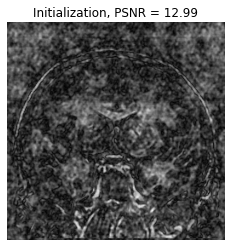

In [8]:
## Display inverse 2D-DFT of observed Fourier coefficients
init_fig = plt.figure()
ax = init_fig.add_subplot(1, 1, 1)
init_plot = plt.imshow(x_init, cmap='gray', vmin=0, vmax=1)
ax.set_title(f'Initialization, PSNR = {peak_signal_noise_ratio(x_init, ORIG):0.2f}')
ax.axis('off')

In [9]:


# filter_array = np.linspace(0, 0.06, 1000)

# patch_kw = dict(patch_size=5,      # 5x5 patches
#                 patch_distance=6,  # 13x13 search area
#                 multichannel=True)

# psnr_list = []
# for i in range(1000):
#     test_denoise = denoise_nl_means(np.real(x_init), h=filter_array[i], fast_mode=True, **patch_kw)
#     psnr_list.append(peak_signal_noise_ratio(test_denoise, ORIG))

# svrg_fig = plt.figure()
# ax = svrg_fig.add_subplot(1, 1, 1)
# svrg_plot = plt.plot(filter_array, psnr_list)
# ax.set_title(f"Filter Size vs. PSNR recovery")
# ax.axis('on')
# plt.show()

$\begin{equation}
	\textbf{PnP-SVRG}(\boldsymbol{x}_0, \eta, T_1, T_2): \\
	\text{for } s = 1, 2, . . ., T_1 \text{ do} \\
	\hspace{2ex} \tilde{\boldsymbol{x}} = \boldsymbol{x}_{s-1} \\
	\hspace{2ex} \boldsymbol{w} = \underbrace{\nabla d(\tilde{\boldsymbol{x}})}_{\text{full gradient}} \\
	\hspace{2ex} \boldsymbol{x}_0 = \tilde{\boldsymbol{x}} \\
	\hspace{2ex} \text{for } t = 1, 2, . . ., T_2 \text{ do} \\
	\hspace{4ex} \text{pick } i_t \in \{ 1, ..., m \} \text{ randomly} \\
	\hspace{4ex} \boldsymbol{v}_t = \underbrace{\nabla d_{i_t} (\boldsymbol{x}_{t-1}) - \nabla d_{i_t} (\tilde{\boldsymbol{x}}) + \boldsymbol{w}}_{\text{stochastic variance-reduced gradient}} \\
	\hspace{4ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_{t-1} - \eta \boldsymbol{v}_t) \\
	\hspace{2ex} \text{end} \\
	\hspace{2ex} \text{set } \boldsymbol{x}_s = \boldsymbol{x}_{T_2} \\
	\text{end} \\
    \textbf{Output } \boldsymbol{x}_{T_1}
\end{equation}$

In [10]:
def PnP_SVRG_CSMRI(z, MASK, meas, eta, T1, T2, batch_size, FILTER, patch, orig):
    ## See pseudocode above

    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask

    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t0 = 0

    ## Main PnP SVRG routine
    for i in range(T1):
        # outer loop
        mu = full_grad(z, MASK, meas) / np.count_nonzero(MASK)   	# Gradient at reference point
        w = np.copy(z) 					# Initialize reference point
        start_iter = time.time()

        for j in range(T2):
            ## inner loop
            ind = get_batch(batch_size, MASK) 	# Get batch index(indices) in terms of (row, col)

            ## calculate stochastic variance-reduced gradient
            v = stoch_grad(z, ind, meas) / batch_size - stoch_grad(w, ind, meas) / batch_size + mu 

            ## take gradient step
            z = z - eta*v

            print("grad " + str(i) + " " + str(j) + " " + str(peak_signal_noise_ratio(orig, z)) + " " + str(np.linalg.norm(meas - MASK * np.fft.fft2(z)**2, 'fro')))            
            
            # Denoising
            ztilde = np.copy(z)
            z = denoise_nl_means(ztilde, h=FILTER, fast_mode=True, **patch)
            
            print("denoise " + str(i) + " " + str(j) + " " + str(peak_signal_noise_ratio(orig, z)))

        ## Calculate time and PSNR difference per outer loop
        stop_iter = time.time()
        time_per_iter.append(stop_iter - start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(ORIG, z))
    ## Output final iterate, time keeping
    return z, time_per_iter, psnr_per_iter

In [ ]:
## Run PnP-SVRG
T_outer = 300 				# Number of outer loop iterations
T_inner = 50 				# Number of inner loop iterations
eta_SVRG = 100 				# step size for SVRG
batch_size_SVRG= int(np.rint(np.count_nonzero(mask) / T_inner))
NLM_filter = 0.01
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_SVRG, time_per_iter_SVRG, psnr_per_iter_SVRG = PnP_SVRG_CSMRI(x_init, mask, y, eta_SVRG, \
                                                                     T_outer, T_inner, batch_size_SVRG, \
                                                                     NLM_filter, patch_kw, ORIG)


grad 0 0 13.006850918674214 2028867.7557785811
denoise 0 0 13.006900991136042
grad 0 1 13.021738718005489 2027902.854996162
denoise 0 1 13.021790023965092
grad 0 2 13.036647396053356 2027068.3284091016
denoise 0 2 13.03670070134742
grad 0 3 13.051578146991687 2026341.5042497301
denoise 0 3 13.051633280361195
grad 0 4 13.066459793317016 2025740.7132218243
denoise 0 4 13.06651515025397
grad 0 5 13.081303757938269 2025842.2225733434
denoise 0 5 13.081358168312638
grad 0 6 13.096217359359962 2025471.0241945207
denoise 0 6 13.096270867075997
grad 0 7 13.111136313194024 2025232.1534693174
denoise 0 7 13.11118911312758
grad 0 8 13.125955951756064 2025190.0099825899
denoise 0 8 13.12600830830254
grad 0 9 13.14088562707367 2025240.5561749125
denoise 0 9 13.140938608028794
grad 0 10 13.15582340626738 2025432.2130037616
denoise 0 10 13.155877478071279
grad 0 11 13.170759157578093 2025781.6486748822
denoise 0 11 13.170813959628608
grad 0 12 13.18570694878922 2026275.1869205567
denoise 0 12 13.1857

denoise 2 5 14.488719727389745
grad 2 6 14.501648466472359 2924446.8123035072
denoise 2 6 14.501877472044711
grad 2 7 14.514867250659776 2943400.056021146
denoise 2 7 14.51509980261298
grad 2 8 14.528049959973437 2962566.0031748987
denoise 2 8 14.528281352087468
grad 2 9 14.54123775771337 2981942.581654771
denoise 2 9 14.541463037070034
grad 2 10 14.55440784102298 3001530.2641039505
denoise 2 10 14.554619774406788
grad 2 11 14.567542784712892 3020910.58470019
denoise 2 11 14.567742706720354
grad 2 12 14.580658241446727 3040813.6997703444
denoise 2 12 14.58085005022327
grad 2 13 14.593736363444341 3060975.4479543474
denoise 2 13 14.593929298132672
grad 2 14 14.606849060035232 3081290.548669005
denoise 2 14 14.60704551920234
grad 2 15 14.619847007220294 3101802.4556285013
denoise 2 15 14.620054709441515
grad 2 16 14.632951674907108 3122536.071050821
denoise 2 16 14.633192359684466
grad 2 17 14.646145610886434 3143468.6714092186
denoise 2 17 14.646444067597228
grad 2 18 14.659326456831574

denoise 4 10 15.819765944852666
grad 4 11 15.830725679627273 5441170.158133539
denoise 4 11 15.832237875866308
grad 4 12 15.843245264698954 5468465.561503105
denoise 4 12 15.84463224440194
grad 4 13 15.855609655707381 5496336.998589255
denoise 4 13 15.856983771870325
grad 4 14 15.868027611863871 5524594.45617301
denoise 4 14 15.869423285235131
grad 4 15 15.88034980249325 5553012.2210439015
denoise 4 15 15.881769869081772
grad 4 16 15.892664875033855 5581468.440616072
denoise 4 16 15.893967596420087
grad 4 17 15.90457260936116 5608189.127865127
denoise 4 17 15.905756682022155
grad 4 18 15.91682430315503 5636117.48945343
denoise 4 18 15.917860525325738
grad 4 19 15.928762189622262 5663602.69772922
denoise 4 19 15.929800278447178
grad 4 20 15.94075087887742 5690910.252592765
denoise 4 20 15.941914043029367
grad 4 21 15.952861329901339 5718817.638284729
denoise 4 21 15.954300872681165
grad 4 22 15.965112571988298 5747256.938028916
denoise 4 22 15.966684863562694
grad 4 23 15.97721804496337

denoise 6 16 16.97438763613382
grad 6 17 16.983695371325677 8339377.57452603
denoise 6 17 16.983878426133977
grad 6 18 16.993211485779284 8369333.083787456
denoise 6 18 16.993356204738557
grad 6 19 17.002628631334417 8399240.890928974
denoise 6 19 17.002660325007533
grad 6 20 17.011965142529768 8429255.792036243
denoise 6 20 17.01198400182834
grad 6 21 17.020849797524445 8458934.829518376
denoise 6 21 17.02089422261181
grad 6 22 17.030238837721406 8489099.442789916
denoise 6 22 17.030311485061816
grad 6 23 17.039592395456452 8519435.763380833
denoise 6 23 17.039700179840192
grad 6 24 17.048963377838728 8549878.39091978
denoise 6 24 17.049193401230692
grad 6 25 17.05848536300211 8580471.145039491
denoise 6 25 17.058891213452636
grad 6 26 17.068114997185177 8611676.22288799
denoise 6 26 17.06853357985087
grad 6 27 17.07774196163064 8643130.67358651
denoise 6 27 17.078089556698302
grad 6 28 17.087453283843722 8673730.870926557
denoise 6 28 17.087785653014414
grad 6 29 17.09702346751949 87

denoise 8 22 17.812383091033396
grad 8 23 17.820459618042594 11143288.64140633
denoise 8 23 17.81940577177028
grad 8 24 17.827509043242816 11169654.641094238
denoise 8 24 17.826402209785442
grad 8 25 17.834489810524296 11196218.468345493
denoise 8 25 17.833306048324093
grad 8 26 17.841387043839422 11222801.28661927
denoise 8 26 17.840352205430385
grad 8 27 17.84838519051688 11249132.505759455
denoise 8 27 17.847405906514222
grad 8 28 17.855576782005855 11275291.101590093
denoise 8 28 17.854584930476744
grad 8 29 17.862345538217294 11301587.56414654
denoise 8 29 17.861266783826927
grad 8 30 17.869311386114777 11328133.33379116
denoise 8 30 17.86820466567974
grad 8 31 17.876326472765395 11354684.13041415
denoise 8 31 17.875181395932206
grad 8 32 17.883227544776346 11381264.089219641
denoise 8 32 17.882106812244718
grad 8 33 17.890178091325293 11408062.240736907
denoise 8 33 17.889070971163534
grad 8 34 17.897137615447647 11434965.354516359
denoise 8 34 17.89602321164158
grad 8 35 17.9041

denoise 10 26 18.493913990034166
grad 10 27 18.50043418511663 13591714.573365321
denoise 10 27 18.499326851001204
grad 10 28 18.506514677016487 13612990.92179882
denoise 10 28 18.50540524003158
grad 10 29 18.51233088645623 13630677.795788867
denoise 10 29 18.511220320884266
grad 10 30 18.518423526539692 13652133.312164985
denoise 10 30 18.517330520265368
grad 10 31 18.524511710954474 13673637.439295074
denoise 10 31 18.523448213467304
grad 10 32 18.530666711332554 13695485.662656764
denoise 10 32 18.529665237294147
grad 10 33 18.53681201906891 13718031.976925962
denoise 10 33 18.53564226831405
grad 10 34 18.542835747746462 13739622.880618632
denoise 10 34 18.54171551926254
grad 10 35 18.548847347697276 13761322.287306773
denoise 10 35 18.547839291793025
grad 10 36 18.554838866822323 13781673.107343562
denoise 10 36 18.55362240582696
grad 10 37 18.56082863405614 13803327.772189112
denoise 10 37 18.559603682751817
grad 10 38 18.565862023162826 13785759.12516313
denoise 10 38 18.564643823

denoise 12 28 19.046094069878567
grad 12 29 19.052566158110263 15494158.83743509
denoise 12 29 19.051146003586055
grad 12 30 19.05757220629233 15512028.15087894
denoise 12 30 19.056162782690073
grad 12 31 19.062655926582405 15529928.41117657
denoise 12 31 19.06123929152476
grad 12 32 19.067731663213788 15547821.554566693
denoise 12 32 19.06629910490752
grad 12 33 19.072744900967525 15565710.754290242
denoise 12 33 19.0713246237977
grad 12 34 19.07783533433839 15583611.961071318
denoise 12 34 19.076399601649285
grad 12 35 19.082851328671858 15601470.83511408
denoise 12 35 19.081415025217936
grad 12 36 19.087893312522667 15619313.36854319
denoise 12 36 19.086460946686728
grad 12 37 19.09284281942584 15637244.358418757
denoise 12 37 19.091393755263297
grad 12 38 19.097836870718968 15655232.712984795
denoise 12 38 19.096395198717186
grad 12 39 19.102857295176918 15673237.58498854
denoise 12 39 19.101414663011965
grad 12 40 19.107869403527772 15691264.647909576
denoise 12 40 19.106411298557

denoise 14 30 19.508101096689398
grad 14 31 19.51399521282566 17057027.89754706
denoise 14 31 19.51235551770915
grad 14 32 19.51820242193229 17070881.642407075
denoise 14 32 19.516566699786683
grad 14 33 19.52246444661601 17084777.673673537
denoise 14 33 19.520825339810298
grad 14 34 19.526717745113046 17098691.771941278
denoise 14 34 19.525093290029815
grad 14 35 19.530835947087805 17110938.27525319
denoise 14 35 19.529230597893854
grad 14 36 19.53510577733185 17125086.75911142
denoise 14 36 19.533507046635062
grad 14 37 19.53938195393266 17139343.165604927
denoise 14 37 19.537787001689676
grad 14 38 19.54359350077339 17153679.31702186
denoise 14 38 19.54201360375029
grad 14 39 19.54783030096048 17166204.43443401
denoise 14 39 19.546247393260217
grad 14 40 19.552146197192517 17180594.000985447
denoise 14 40 19.550570430956633
grad 14 41 19.556153249064078 17194998.626235303
denoise 14 41 19.554604976441862
grad 14 42 19.560294197250307 17209342.940400064
denoise 14 42 19.5587560585459

denoise 16 32 19.906100731987376
grad 16 33 19.911481779477338 18342442.256500613
denoise 16 33 19.909785343734136
grad 16 34 19.915027312319566 18340780.75684322
denoise 16 34 19.913353899543537
grad 16 35 19.918614226521445 18352914.887710646
denoise 16 35 19.916931915220783
grad 16 36 19.922321529329125 18365077.582149297
denoise 16 36 19.920635091954562
grad 16 37 19.926024704918042 18377242.940149955
denoise 16 37 19.924333908399273
grad 16 38 19.92972255837945 18389440.85731787
denoise 16 38 19.92803068538097
grad 16 39 19.933432932905863 18401659.925756693
denoise 16 39 19.931738471896033
grad 16 40 19.937130896447172 18413892.47016237
denoise 16 40 19.935432428771087
grad 16 41 19.940800479939288 18426083.081583984
denoise 16 41 19.939083058219534
grad 16 42 19.94440959910995 18438289.889601685
denoise 16 42 19.942704987405804
grad 16 43 19.94773567945926 18433941.64320514
denoise 16 43 19.94602608476603
grad 16 44 19.95140728221559 18446126.35814765
denoise 16 44 19.9496853868

denoise 18 34 20.252386832398244
grad 18 35 20.2573052688254 19389288.362493966
denoise 18 35 20.255473829691006
grad 18 36 20.260433846152324 19399279.723523974
denoise 18 36 20.258608485711104
grad 18 37 20.263571702067296 19409261.534819663
denoise 18 37 20.2617321198978
grad 18 38 20.26667006365151 19418491.83779145
denoise 18 38 20.264845715190553
grad 18 39 20.269817684147583 19428530.116144173
denoise 18 39 20.267979352975367
grad 18 40 20.272947154674142 19438583.307713598
denoise 18 40 20.27110574577074
grad 18 41 20.2760489736508 19448623.742951177
denoise 18 41 20.274210432048584
grad 18 42 20.27919390012931 19458703.502030116
denoise 18 42 20.27735020267108
grad 18 43 20.28231793330089 19468797.44198943
denoise 18 43 20.280468813824765
grad 18 44 20.28542930833805 19478878.01366958
denoise 18 44 20.28358466024706
grad 18 45 20.288567042097494 19488959.290551204
denoise 18 45 20.286719279113264
grad 18 46 20.291635907835545 19499070.74638283
denoise 18 46 20.289783699521738


denoise 20 36 20.54721718642467
grad 20 37 20.551809433410334 20260112.955698743
denoise 20 37 20.549964336653822
grad 20 38 20.55458160409701 20268601.64438045
denoise 20 38 20.55273427479265
grad 20 39 20.557303087863744 20277098.928567264
denoise 20 39 20.555459782642394
grad 20 40 20.559967493525445 20285585.78475653
denoise 20 40 20.55812948673148
grad 20 41 20.562698249630685 20294101.471035153
denoise 20 41 20.56085554240852
grad 20 42 20.565462495750822 20302627.176533464
denoise 20 42 20.56361477512705
grad 20 43 20.567994744723368 20310982.59400812
denoise 20 43 20.566153516127464
grad 20 44 20.57078696262183 20319526.010207683
denoise 20 44 20.568938126533105
grad 20 45 20.57352227094156 20328079.862912904
denoise 20 45 20.571672341086455
grad 20 46 20.576263879778047 20336604.896348275
denoise 20 46 20.574414743547198
grad 20 47 20.579014083390057 20345163.56050492
denoise 20 47 20.577160622457544
grad 20 48 20.581714301261094 20353700.39101418
denoise 20 48 20.579869317004

denoise 22 38 20.807805542086637
grad 22 39 20.812116163889556 21028651.64719245
denoise 22 39 20.810238197862372
grad 22 40 20.81436268637168 21035907.967700455
denoise 22 40 20.812496423730863
grad 22 41 20.816801144641953 21043164.995897416
denoise 22 41 20.814921622639353
grad 22 42 20.81921565224938 21050408.037618514
denoise 22 42 20.817339169244356
grad 22 43 20.82162664453557 21057648.35447421
denoise 22 43 20.819743230859785
grad 22 44 20.82403362445745 21064879.418175835
denoise 22 44 20.822145896963356
grad 22 45 20.82643749978624 21072101.105804067
denoise 22 45 20.82454726012294
grad 22 46 20.828809698820244 21079322.183192186
denoise 22 46 20.82692405863822
grad 22 47 20.8311997643521 21086524.258219313
denoise 22 47 20.82931087922638
grad 22 48 20.833610703303307 21093768.188740697
denoise 22 48 20.831726996472156
grad 22 49 20.835998649508017 21101027.775135882
denoise 22 49 20.834106239622304
grad 23 0 20.838331491468047 21107529.224350993
denoise 23 0 20.8364430782078

denoise 24 40 21.0332171841057
grad 24 41 21.037243415211513 21660925.3935785
denoise 24 41 21.035299504948476
grad 24 42 21.03934657351763 21666969.890076768
denoise 24 42 21.037413101936664
grad 24 43 21.041436712256427 21673019.858217455
denoise 24 43 21.039488125464764
grad 24 44 21.043359935689246 21678929.145489894
denoise 24 44 21.041409073725102
grad 24 45 21.045444406458135 21684649.1348903
denoise 24 45 21.0434980778167
grad 24 46 21.04753791994404 21690703.041939523
denoise 24 46 21.04559221037978
grad 24 47 21.04961117072802 21696533.642981615
denoise 24 47 21.0476638937312
grad 24 48 21.051419379474726 21702587.592705153
denoise 24 48 21.049471018688088
grad 24 49 21.05349261365076 21708619.59754244
denoise 24 49 21.051539646162357
grad 25 0 21.05551667595153 21714106.415959097
denoise 25 0 21.053570120212658
grad 25 1 21.05754591076348 21719592.83543767
denoise 25 1 21.05559971211456
grad 25 2 21.059573585569286 21725080.36590217
denoise 25 2 21.05762734598065
grad 25 3 2

denoise 26 44 21.233558717800204
grad 26 45 21.237355959572074 22211263.918960214
denoise 26 45 21.235378654520026
grad 26 46 21.23900424769443 22212346.43680898
denoise 26 46 21.237024583303338
grad 26 47 21.240837534702557 22217504.04065668
denoise 26 47 21.238857361094453
grad 26 48 21.24267684048438 22222672.142959103
denoise 26 48 21.24069398376665
grad 26 49 21.244498339053166 22227843.520606812
denoise 26 49 21.242514950095924
grad 27 0 21.24627793140192 22232557.39474596
denoise 27 0 21.244297100153567
grad 27 1 21.24805484093196 22237271.89210378
denoise 27 1 21.24607280659543
grad 27 2 21.24983352838498 22241986.93014173
denoise 27 2 21.247850049087393
grad 27 3 21.25161012374378 22246702.36547226
denoise 27 3 21.249625873341557
grad 27 4 21.25338260205566 22251416.869680908
denoise 27 4 21.25139745865212
grad 27 5 21.255148247546703 22256131.00071295
denoise 27 5 21.253162699813362
grad 27 6 21.256918612531667 22260844.075818066
denoise 27 6 21.254928876333018
grad 27 7 21.2

denoise 28 48 21.410263023538786
grad 28 49 21.41384833786897 22646755.65271871
denoise 28 49 21.411839055135307
grad 29 0 21.415423422245535 22650963.085851382
denoise 29 0 21.413419096024874
grad 29 1 21.417002578879064 22655173.536222015
denoise 29 1 21.415000637903855
grad 29 2 21.418583071214506 22659260.80871909
denoise 29 2 21.41658260614129
grad 29 3 21.420161582847047 22663471.12824059
denoise 29 3 21.418161202982912
grad 29 4 21.42174242846894 22667682.498871315
denoise 29 4 21.41974098361821
grad 29 5 21.423314936927824 22671894.14596341
denoise 29 5 21.42131200421261
grad 29 6 21.42489011239483 22676106.259567868
denoise 29 6 21.422887796033766
grad 29 7 21.426462342929288 22680319.600028597
denoise 29 7 21.4244595213129
grad 29 8 21.4280328978122 22684533.15873606
denoise 29 8 21.426027892514234
grad 29 9 21.429600719159616 22688706.598473545
denoise 29 9 21.427596013102367
grad 29 10 21.431167624782972 22692877.440280553
denoise 29 10 21.42916366515351
grad 29 11 21.43272

denoise 31 2 21.56539765272591
grad 31 3 21.56881806148565 23059359.25304691
denoise 31 3 21.566796788272264
grad 31 4 21.57021572915667 23062959.58346488
denoise 31 4 21.568194436325054
grad 31 5 21.571608356753778 23066549.135214917
denoise 31 5 21.569587274886306
grad 31 6 21.573003152184157 23070147.746800475
denoise 31 6 21.57098255230799
grad 31 7 21.574392326601853 23073722.858671334
denoise 31 7 21.572373181782808
grad 31 8 21.575788953712237 23076975.498772476
denoise 31 8 21.573770060495097
grad 31 9 21.577186392260245 23080572.078792535
denoise 31 9 21.57516516170525
grad 31 10 21.578580841809988 23084164.51821456
denoise 31 10 21.57655634144701
grad 31 11 21.579966943795704 23087721.33899085
denoise 31 11 21.577935663594154
grad 31 12 21.581344725709425 23091236.879580595
denoise 31 12 21.579301673058428
grad 31 13 21.582706113281898 23094740.728845537
denoise 31 13 21.580674397516233
grad 31 14 21.58407821741016 23098319.843983486
denoise 31 14 21.582057547270633
grad 31 1

denoise 33 6 21.702694584931255
grad 33 7 21.705969849515956 23395763.307321995
denoise 33 7 21.703959938265378
grad 33 8 21.70723512316636 23398841.37950768
denoise 33 8 21.705224175184647
grad 33 9 21.70849737897428 23401918.9430178
denoise 33 9 21.706488389945832
grad 33 10 21.709762149849425 23404994.826774936
denoise 33 10 21.707754967980726
grad 33 11 21.711006560089196 23408067.92136716
denoise 33 11 21.70899676347265
grad 33 12 21.71226760237357 23411141.685625054
denoise 33 12 21.710259822361465
grad 33 13 21.71349834518733 23414210.93164731
denoise 33 13 21.711492570126968
grad 33 14 21.714755104921913 23417279.389739476
denoise 33 14 21.71275155466816
grad 33 15 21.71602215118802 23420344.594492845
denoise 33 15 21.714014273011667
grad 33 16 21.717284275419054 23423409.953469265
denoise 33 16 21.715279779479324
grad 33 17 21.718546025568152 23426477.02707135
denoise 33 17 21.716541811960795
grad 33 18 21.719809361020232 23429544.244466882
denoise 33 18 21.71780438055217
grad

denoise 35 8 21.825374658087583
grad 35 9 21.82851533951768 23694183.14267007
denoise 35 9 21.826501544515384
grad 35 10 21.82964388463166 23696872.605123695
denoise 35 10 21.827631492927935
grad 35 11 21.830766221350196 23699561.5296412
denoise 35 11 21.82875405189245
grad 35 12 21.831900839737173 23702250.78491166
denoise 35 12 21.829882664468524
grad 35 13 21.833018564689834 23704937.767546844
denoise 35 13 21.831000542439707
grad 35 14 21.834150311793408 23707626.796635848
denoise 35 14 21.83212908054977
grad 35 15 21.8352756880307 23710319.394603726
denoise 35 15 21.83325640558791
grad 35 16 21.836370335163107 23713006.931065142
denoise 35 16 21.834352654993133
grad 35 17 21.83749762284748 23715700.495703038
denoise 35 17 21.835477933862222
grad 35 18 21.83862009539563 23718393.45932042
denoise 35 18 21.83660454056443
grad 35 19 21.83974823528625 23721088.716961738
denoise 35 19 21.837729031064562
grad 35 20 21.84086345004968 23723779.63303629
denoise 35 20 21.838845361864433
grad

denoise 37 10 21.934991016018607
grad 37 11 21.938037155594564 23948321.488858964
denoise 37 11 21.93603023316282
grad 37 12 21.93907302003153 23950601.23519708
denoise 37 12 21.93706024536067
grad 37 13 21.940099291379273 23952852.142015077
denoise 37 13 21.938085295330396
grad 37 14 21.9411311953327 23954864.99325659
denoise 37 14 21.939114680554724
grad 37 15 21.942159622929637 23957079.307806615
denoise 37 15 21.9401389054909
grad 37 16 21.943184033822757 23959274.591112655
denoise 37 16 21.941165767905435
grad 37 17 21.94420108374853 23961473.216939203
denoise 37 17 21.942182116348942
grad 37 18 21.945225234153376 23963689.132120106
denoise 37 18 21.943211430936742
grad 37 19 21.946245822869276 23965927.74311169
denoise 37 19 21.944225686422673
grad 37 20 21.947274557008893 23968199.51242403
denoise 37 20 21.94524240086979
grad 37 21 21.94828799321644 23970496.470355053
denoise 37 21 21.946264385549505
grad 37 22 21.949296950152405 23972826.58583192
denoise 37 22 21.94727766443069

denoise 39 12 22.03472769350605
grad 39 13 22.03767869426299 24175572.27145839
denoise 39 13 22.035650706927964
grad 39 14 22.03860055916209 24177710.2956006
denoise 39 14 22.03657129846559
grad 39 15 22.039523116524617 24179828.134358548
denoise 39 15 22.037493693169353
grad 39 16 22.040445922714852 24181742.40620655
denoise 39 16 22.038415973584375
grad 39 17 22.041362791730545 24183880.863533262
denoise 39 17 22.03933544601027
grad 39 18 22.042281092262353 24186022.27187524
denoise 39 18 22.040254369092874
grad 39 19 22.043197167052142 24188160.396037765
denoise 39 19 22.04117183059184
grad 39 20 22.044120352377703 24190302.76990593
denoise 39 20 22.042090553991596
grad 39 21 22.04503660252786 24192439.92375587
denoise 39 21 22.043009640984078
grad 39 22 22.045949333230283 24194578.03063534
denoise 39 22 22.043920062324656
grad 39 23 22.046867348175475 24196713.21914738
denoise 39 23 22.044840444176618
grad 39 24 22.04777539999445 24198849.7236005
denoise 39 24 22.045751189451632
gr

denoise 41 16 22.127146749996953
grad 41 17 22.130004600994027 24374757.247572258
denoise 41 17 22.12799320701517
grad 41 18 22.13084544786433 24376538.504156437
denoise 41 18 22.12883340157061
grad 41 19 22.131693000317256 24378321.547432203
denoise 41 19 22.129678967077957
grad 41 20 22.132529389396744 24380097.82224656
denoise 41 20 22.130514020109196
grad 41 21 22.13337291008135 24381877.866274722
denoise 41 21 22.13135816477916
grad 41 22 22.134213005534566 24383656.954765815
denoise 41 22 22.132199363914285
grad 41 23 22.135052087277924 24385437.240327124
denoise 41 23 22.133040609065397
grad 41 24 22.135891174612237 24387216.823609494
denoise 41 24 22.133875423141163
grad 41 25 22.136729763138238 24388996.048005253
denoise 41 25 22.13471452588672
grad 41 26 22.137562017760438 24390780.273113262
denoise 41 26 22.13555005836533
grad 41 27 22.13840053204394 24392563.405841652
denoise 41 27 22.136388687502347
grad 41 28 22.139246490254095 24394345.04288703
denoise 41 28 22.137232684

denoise 43 18 22.209080165450743
grad 43 19 22.21186281692839 24530107.901546076
denoise 43 19 22.209855882009574
grad 43 20 22.21260864070731 24531665.46532369
denoise 43 20 22.210605478518445
grad 43 21 22.213377208642342 24533228.052063126
denoise 43 21 22.211374124118677
grad 43 22 22.214151548639865 24534796.138106715
denoise 43 22 22.212146651477816
grad 43 23 22.21491845132823 24536362.18677034
denoise 43 23 22.212914524236442
grad 43 24 22.21569351107958 24537751.927955866
denoise 43 24 22.213687445543933
grad 43 25 22.2164595080772 24539321.729085725
denoise 43 25 22.21445506445373
grad 43 26 22.217231392715448 24540898.59523994
denoise 43 26 22.215226162598782
grad 43 27 22.218004258610566 24542473.853875037
denoise 43 27 22.215994209566258
grad 43 28 22.21876072643174 24544044.551677175
denoise 43 28 22.21675253619063
grad 43 29 22.21949420158029 24545603.741280485
denoise 43 29 22.217488589020704
grad 43 30 22.22024268663609 24547135.875358168
denoise 43 30 22.2182338312083

denoise 45 20 22.284512728621408
grad 45 21 22.287215496989845 24679481.396128226
denoise 45 21 22.28523015653037
grad 45 22 22.287938159506048 24680878.70858874
denoise 45 22 22.28595250909171
grad 45 23 22.288659584574276 24682278.692546856
denoise 45 23 22.286675975799753
grad 45 24 22.289386366602372 24683677.143270813
denoise 45 24 22.287402082831335
grad 45 25 22.29010853287745 24685079.877680734
denoise 45 25 22.288129613594975
grad 45 26 22.29083628401991 24686486.785149418
denoise 45 26 22.288866051909704
grad 45 27 22.29157581693958 24687902.646178786
denoise 45 27 22.28960731035679
grad 45 28 22.292302340942722 24689335.8752962
denoise 45 28 22.2903415842222
grad 45 29 22.29304051569542 24690781.7109128
denoise 45 29 22.291074786681545
grad 45 30 22.29378177278184 24692226.397374336
denoise 45 30 22.291801906039748
grad 45 31 22.294481204357982 24693640.294568717
denoise 45 31 22.29249924786235
grad 45 32 22.2952031140792 24695051.24917085
denoise 45 32 22.2932101348555
grad

denoise 47 24 22.35549009465977
grad 47 25 22.358149726783626 24810496.330760475
denoise 47 25 22.356157326392513
grad 47 26 22.35881209655584 24811758.20134479
denoise 47 26 22.356824866919986
grad 47 27 22.359457805623556 24813012.620873608
denoise 47 27 22.357473050000927
grad 47 28 22.360123391785017 24814279.11338989
denoise 47 28 22.358138126164043
grad 47 29 22.36078904732162 24815492.958122734
denoise 47 29 22.358802189297244
grad 47 30 22.36145310757465 24816769.176260643
denoise 47 30 22.359466553381857
grad 47 31 22.362117121158374 24818061.511037722
denoise 47 31 22.360121511770025
grad 47 32 22.36276156350494 24819375.298205078
denoise 47 32 22.360774803326066
grad 47 33 22.363427031912344 24820696.57393869
denoise 47 33 22.361426579051418
grad 47 34 22.36408781994252 24822025.69218856
denoise 47 34 22.362091158129434
grad 47 35 22.364731669762254 24823356.33231696
denoise 47 35 22.362741284680297
grad 47 36 22.3653813104592 24824705.18769934
denoise 47 36 22.3633862606205

denoise 49 26 22.421284242403615
grad 49 27 22.4238823319269 24920826.18608937
denoise 49 27 22.42190759812184
grad 49 28 22.424496519959163 24921708.190946683
denoise 49 28 22.422522198885613
grad 49 29 22.425115348631014 24922616.211457875
denoise 49 29 22.423137938080203
grad 49 30 22.425727024453185 24923526.88120368
denoise 49 30 22.42375156349038
grad 49 31 22.42634623843466 24924422.25587904
denoise 49 31 22.42436774649942
grad 49 32 22.426964939757205 24925335.97151604
denoise 49 32 22.42499136875548
grad 49 33 22.427566201149027 24926244.51615124
denoise 49 33 22.4255916756379
grad 49 34 22.428179789404595 24927156.72986661
denoise 49 34 22.426205185390597
grad 49 35 22.42880373907052 24928075.715295244
denoise 49 35 22.426825142374405
grad 49 36 22.429423045770605 24928997.54061724
denoise 49 36 22.42744647578229
grad 49 37 22.430043634433577 24929913.816791933
denoise 49 37 22.428066431630363
grad 49 38 22.430653523985576 24930830.952593103
denoise 49 38 22.428674678337348
g

denoise 51 30 22.483077773425183
grad 51 31 22.485604924303445 25007502.323602617
denoise 51 31 22.483641753864458
grad 51 32 22.486170908117955 25008288.656753946
denoise 51 32 22.484208605257873
grad 51 33 22.48674024146791 25009075.426024456
denoise 51 33 22.48477643793207
grad 51 34 22.48730679803391 25009862.05588018
denoise 51 34 22.485345271642835
grad 51 35 22.48788038928566 25010648.60714145
denoise 51 35 22.485918507146685
grad 51 36 22.488439659983122 25011420.50745052
denoise 51 36 22.48647681652941
grad 51 37 22.489006885935368 25012206.848521322
denoise 51 37 22.48704421691683
grad 51 38 22.489568987811424 25013000.716532476
denoise 51 38 22.487608748455806
grad 51 39 22.49013578151477 25013791.570214584
denoise 51 39 22.48817267936413
grad 51 40 22.490700656530475 25014586.21194006
denoise 51 40 22.48873877470565
grad 51 41 22.49127001427616 25015378.82807724
denoise 51 41 22.48930599735058
grad 51 42 22.491834593629505 25016434.261995643
denoise 51 42 22.48986957499251


denoise 53 34 22.538958701505724
grad 53 35 22.541437262419713 25080147.23465216
denoise 53 35 22.539471067404946
grad 53 36 22.54193778287888 25080804.009197135
denoise 53 36 22.539975592845316
grad 53 37 22.542450828914625 25081463.308922935
denoise 53 37 22.540489127155347
grad 53 38 22.54295332367623 25082120.792937774
denoise 53 38 22.540993024068715
grad 53 39 22.543470316354018 25082780.71089057
denoise 53 39 22.54150893955634
grad 53 40 22.54398062384454 25083438.70560942
denoise 53 40 22.542016042022826
grad 53 41 22.544494648027285 25084096.315279923
denoise 53 41 22.54253021834641
grad 53 42 22.54500693744019 25084757.24039022
denoise 53 42 22.543041010448817
grad 53 43 22.545510041480217 25085414.530150887
denoise 53 43 22.54354872779085
grad 53 44 22.54602677221169 25086075.21508103
denoise 53 44 22.54406299677525
grad 53 45 22.546537396666654 25086736.08498968
denoise 53 45 22.544575764063666
grad 53 46 22.547057322421935 25087397.638051763
denoise 53 46 22.5450892798418


denoise 55 36 22.589458496643985
grad 55 37 22.59187887513417 25142338.94051484
denoise 55 37 22.589968414287384
grad 55 38 22.592394794577523 25142935.24698323
denoise 55 38 22.590486290048414
grad 55 39 22.59290388542951 25143532.967740014
denoise 55 39 22.591000436297463
grad 55 40 22.59341436689159 25144127.74853506
denoise 55 40 22.591513805033966
grad 55 41 22.59393920162122 25144729.794683404
denoise 55 41 22.592037714834067
grad 55 42 22.594462082197477 25145325.981141202
denoise 55 42 22.59256029201369
grad 55 43 22.5949799942226 25145936.933499664
denoise 55 43 22.593086660510203
grad 55 44 22.595506148855424 25146551.211776856
denoise 55 44 22.59360884615647
grad 55 45 22.596028397933175 25147165.157935783
denoise 55 45 22.594135746602625
grad 55 46 22.596547260222785 25147778.609366726
denoise 55 46 22.59465781229268
grad 55 47 22.597078324874182 25148390.21089188
denoise 55 47 22.595192388962
grad 55 48 22.597608633038124 25149000.926524956
denoise 55 48 22.595727830779843

denoise 57 40 22.642216147121594
grad 57 41 22.644586014556754 25198800.1255592
denoise 57 41 22.642684761045512
grad 57 42 22.645056184641497 25199323.163095582
denoise 57 42 22.643149840640376
grad 57 43 22.64552521950726 25199844.278053805
denoise 57 43 22.64361989368369
grad 57 44 22.64599107715449 25200368.583945747
denoise 57 44 22.64408925072758
grad 57 45 22.646464925489003 25200893.885311674
denoise 57 45 22.644563730318453
grad 57 46 22.646939622850688 25201421.329058703
denoise 57 46 22.645035309475645
grad 57 47 22.647376173340614 25199918.513913494
denoise 57 47 22.64547176595963
grad 57 48 22.64784754894867 25200446.777946092
denoise 57 48 22.64594733119901
grad 57 49 22.648321275135295 25200978.30240852
denoise 57 49 22.646421826213125
grad 58 0 22.648794179936278 25201477.259576127
denoise 58 0 22.64689284469064
grad 58 1 22.64926468989454 25201976.94253302
denoise 58 1 22.64736288808438
grad 58 2 22.649734434444934 25202485.964491647
denoise 58 2 22.647833171818515
gra

denoise 59 42 22.68965678860721
grad 59 43 22.69199843838512 25246536.691477925
denoise 59 43 22.690076714234436
grad 59 44 22.692418733911673 25246988.840630405
denoise 59 44 22.690506900223735
grad 59 45 22.69284179999993 25247448.45488789
denoise 59 45 22.69093525258199
grad 59 46 22.693258057302454 25247907.436516624
denoise 59 46 22.691351278707394
grad 59 47 22.693687887809155 25248353.995597377
denoise 59 47 22.691781221030467
grad 59 48 22.69412387945065 25248804.296017528
denoise 59 48 22.69222293133104
grad 59 49 22.69455047901889 25249249.75762162
denoise 59 49 22.69265181117353
grad 60 0 22.694982649398902 25249663.70021165
denoise 60 0 22.693085923264494
grad 60 1 22.695416400184204 25250080.72550339
denoise 60 1 22.69352171959374
grad 60 2 22.695851859318775 25250498.881455164
denoise 60 2 22.693957701653865
grad 60 3 22.696287383330606 25250918.050096475
denoise 60 3 22.69439454165228
grad 60 4 22.696723443948414 25251337.40374492
denoise 60 4 22.69483186672312
grad 60 5

denoise 61 44 22.733799302309063
grad 61 45 22.736098805857175 25286278.261963807
denoise 61 45 22.734224224838275
grad 61 46 22.736515443268367 25286696.98443868
denoise 61 46 22.73464284790991
grad 61 47 22.736920953127346 25287117.137842346
denoise 61 47 22.73505647879785
grad 61 48 22.737347057485096 25287551.926008996
denoise 61 48 22.735476367315734
grad 61 49 22.737760164662074 25287977.590644162
denoise 61 49 22.73589110495092
grad 62 0 22.73817924305191 25288387.037874475
denoise 62 0 22.736306110469542
grad 62 1 22.738593925134648 25288804.905570533
denoise 62 1 22.736720334540706
grad 62 2 22.739007772252194 25289216.561055757
denoise 62 2 22.73713247061094
grad 62 3 22.73941961862818 25289630.487918817
denoise 62 3 22.73754233139437
grad 62 4 22.73982912374988 25290046.61278922
denoise 62 4 22.73794917150991
grad 62 5 22.74023444768528 25290460.014602635
denoise 62 5 22.738350370076468
grad 62 6 22.740636905581578 25290880.586054888
denoise 62 6 22.738744099442165
grad 62 7

denoise 63 46 22.772076915516656
grad 63 47 22.77433272019198 25329542.014510743
denoise 63 47 22.77246742845689
grad 63 48 22.774725213466244 25329936.92050494
denoise 63 48 22.772866311489828
grad 63 49 22.775126884308868 25330332.500793368
denoise 63 49 22.773264965749526
grad 64 0 22.775517991562108 25330704.17624724
denoise 64 0 22.773655609963225
grad 64 1 22.775908070402217 25331073.97212314
denoise 64 1 22.774045437247242
grad 64 2 22.77629741041439 25331443.367875844
denoise 64 2 22.77443437796407
grad 64 3 22.776686179654597 25331812.426026564
denoise 64 3 22.774823386409338
grad 64 4 22.777074083482105 25332180.803355325
denoise 64 4 22.775212824694062
grad 64 5 22.777464198327255 25332548.472272042
denoise 64 5 22.775602097455945
grad 64 6 22.777852525479396 25332933.612734456
denoise 64 6 22.77599097984645
grad 64 7 22.778241015706588 25333301.721360546
denoise 64 7 22.776380216736257
grad 64 8 22.778630070349482 25333670.65289982
denoise 64 8 22.776769474501364
grad 64 9 

denoise 66 0 22.81141642969461
grad 66 1 22.813630933652295 25365916.2328323
denoise 66 1 22.811786917193665
grad 66 2 22.81400012797446 25366232.355668645
denoise 66 2 22.812156352178626
grad 66 3 22.81436991560834 25366548.3107027
denoise 66 3 22.81252547762942
grad 66 4 22.814738681926393 25366864.345314514
denoise 66 4 22.812894357366464
grad 66 5 22.815106736421452 25367180.065607686
denoise 66 5 22.813262697015286
grad 66 6 22.815474867767236 25367495.929217692
denoise 66 6 22.813631671753004
grad 66 7 22.815843182186516 25367811.909149185
denoise 66 7 22.81399978088432
grad 66 8 22.8162112990484 25368128.50328088
denoise 66 8 22.814368332438978
grad 66 9 22.816580946827038 25368444.445454996
denoise 66 9 22.814737550522345
grad 66 10 22.81694852940285 25368760.339939203
denoise 66 10 22.815105101900926
grad 66 11 22.817316141077896 25369076.606169704
denoise 66 11 22.815472793826466
grad 66 12 22.817683689582047 25369392.972927205
denoise 66 12 22.81584099057215
grad 66 13 22.81

denoise 68 2 22.848984856733136
grad 68 3 22.8511627187118 25397321.897930875
denoise 68 3 22.849350767627392
grad 68 4 22.85152839138034 25397617.912413526
denoise 68 4 22.84971714372419
grad 68 5 22.85189410750003 25397915.729607295
denoise 68 5 22.850083350609044
grad 68 6 22.852260707565343 25398213.46396369
denoise 68 6 22.850450140249897
grad 68 7 22.852626506414616 25398509.687668767
denoise 68 7 22.8508161668475
grad 68 8 22.852991632610955 25398806.539113387
denoise 68 8 22.851183006515615
grad 68 9 22.853359031556487 25399103.937591765
denoise 68 9 22.85155221344605
grad 68 10 22.853727638150012 25399403.84459375
denoise 68 10 22.85192153482854
grad 68 11 22.854095251932268 25399702.1252156
denoise 68 11 22.852288673695107
grad 68 12 22.854462682503996 25399997.965905875
denoise 68 12 22.85265543237527
grad 68 13 22.854829996732825 25400293.47967514
denoise 68 13 22.853023952201518
grad 68 14 22.855199457350377 25400588.10341645
denoise 68 14 22.8533915512823
grad 68 15 22.85

denoise 70 4 22.88640849929689
grad 70 5 22.888552153953775 25429213.471271414
denoise 70 5 22.886784060210697
grad 70 6 22.8889274314117 25429555.82447331
denoise 70 6 22.887158567260624
grad 70 7 22.889300837326225 25429895.033141304
denoise 70 7 22.887532822310426
grad 70 8 22.889672836383994 25430232.614496123
denoise 70 8 22.887905590672354
grad 70 9 22.89004509533622 25430565.0291026
denoise 70 9 22.888277827937273
grad 70 10 22.890418355364663 25430895.673199765
denoise 70 10 22.88864896963352
grad 70 11 22.890789854068245 25431219.857784864
denoise 70 11 22.889022872320545
grad 70 12 22.89116244014627 25431545.923946515
denoise 70 12 22.88939694068699
grad 70 13 22.891534007296514 25431869.281420525
denoise 70 13 22.88976768793331
grad 70 14 22.891910341787188 25432190.59040342
denoise 70 14 22.89014228108657
grad 70 15 22.89228239381046 25432510.43826258
denoise 70 15 22.890513510548402
grad 70 16 22.892655136741897 25432826.261471413
denoise 70 16 22.890885810361553
grad 70 1

denoise 72 6 22.923033439658745
grad 72 7 22.925143766240097 25459250.732356314
denoise 72 7 22.923402664804197
grad 72 8 22.92551179085885 25459654.217161946
denoise 72 8 22.92376462255355
grad 72 9 22.925874555345164 25460017.801650666
denoise 72 9 22.924123710907246
grad 72 10 22.92623322504026 25460337.526821904
denoise 72 10 22.924481196649396
grad 72 11 22.926589138164545 25460632.618756577
denoise 72 11 22.92483828510495
grad 72 12 22.926948249457627 25460913.93045351
denoise 72 12 22.92519918621394
grad 72 13 22.927308990162715 25461184.481778502
denoise 72 13 22.925559502057936
grad 72 14 22.927667451547368 25461445.84406608
denoise 72 14 22.925919709602013
grad 72 15 22.928028774081564 25461700.057339624
denoise 72 15 22.926283765961365
grad 72 16 22.92839264300696 25461947.98088799
denoise 72 16 22.926648659669873
grad 72 17 22.928757366853635 25462192.876166675
denoise 72 17 22.927017208368575
grad 72 18 22.929122859301117 25462432.966941595
denoise 72 18 22.927387487598434

denoise 74 8 22.957683785001322
grad 74 9 22.959762051757675 25483826.542090464
denoise 74 9 22.958010795212793
grad 74 10 22.960086241983355 25484062.220091265
denoise 74 10 22.95833624442016
grad 74 11 22.960414164094583 25484293.710155476
denoise 74 11 22.958664652731873
grad 74 12 22.960740337635993 25484554.05953352
denoise 74 12 22.95899220920649
grad 74 13 22.961070275668746 25484780.468614433
denoise 74 13 22.95932261225237
grad 74 14 22.961398111387528 25485005.121498782
denoise 74 14 22.959652335589738
grad 74 15 22.961727047463487 25485231.054925967
denoise 74 15 22.95998011176043
grad 74 16 22.96205744634154 25485457.482915297
denoise 74 16 22.960312334779974
grad 74 17 22.962389141107764 25485678.81338497
denoise 74 17 22.960644178532725
grad 74 18 22.96272221838307 25485899.929143276
denoise 74 18 22.96097593344751
grad 74 19 22.963050441136915 25486121.110170748
denoise 74 19 22.961306349424426
grad 74 20 22.963384494218047 25486343.971743796
denoise 74 20 22.96163640104

denoise 76 10 22.992233301506452
grad 76 11 22.994285725624483 25505031.28963757
denoise 76 11 22.99255951328467
grad 76 12 22.994608243402205 25505232.84569269
denoise 76 12 22.99288309753929
grad 76 13 22.994934651437863 25505436.309423376
denoise 76 13 22.993208937035693
grad 76 14 22.99526049005795 25505640.701975882
denoise 76 14 22.993534823857722
grad 76 15 22.995586396172044 25505846.13418803
denoise 76 15 22.993859122736566
grad 76 16 22.99590984036874 25506053.956224684
denoise 76 16 22.99418179556546
grad 76 17 22.99623065566226 25506262.30306052
denoise 76 17 22.994502282266218
grad 76 18 22.996553251041526 25506472.475288395
denoise 76 18 22.994822206915075
grad 76 19 22.996872297448654 25506686.195442986
denoise 76 19 22.99513973302613
grad 76 20 22.997188229273362 25506901.54914025
denoise 76 20 22.99545360639953
grad 76 21 22.997503682926954 25507121.328551486
denoise 76 21 22.995766028064427
grad 76 22 22.997811838774055 25507343.965816114
denoise 76 22 22.996070729290

denoise 78 12 23.024019061260383
grad 78 13 23.026041841970454 25523934.287375424
denoise 78 13 23.02432254204021
grad 78 14 23.02634380263907 25524064.67882156
denoise 78 14 23.024625574303506
grad 78 15 23.026647734548966 25524196.01559445
denoise 78 15 23.02492992386083
grad 78 16 23.026953639811985 25524327.130355787
denoise 78 16 23.025236130904375
grad 78 17 23.02725855968141 25524456.85712549
denoise 78 17 23.025539579063047
grad 78 18 23.027559711254764 25524338.336639777
denoise 78 18 23.02584047235744
grad 78 19 23.027860795598123 25524466.926602606
denoise 78 19 23.02614620061958
grad 78 20 23.028163504066114 25524571.341358718
denoise 78 20 23.026451528029366
grad 78 21 23.02846949576449 25524646.848279323
denoise 78 21 23.026757113490447
grad 78 22 23.028779573047643 25524727.845387593
denoise 78 22 23.027065718338346
grad 78 23 23.029084955309255 25524815.097664602
denoise 78 23 23.027371207026945
grad 78 24 23.029392974166303 25524914.442608614
denoise 78 24 23.027679169

denoise 80 14 23.054222355285386
grad 80 15 23.056226707066667 25534168.85630574
denoise 80 15 23.05448579425244
grad 80 16 23.05649004889354 25534184.683577612
denoise 80 16 23.054751269802104
grad 80 17 23.056755812458235 25534202.18602441
denoise 80 17 23.055014750090173
grad 80 18 23.057013129188828 25534224.23051215
denoise 80 18 23.05527951035334
grad 80 19 23.05728317600165 25534245.99896428
denoise 80 19 23.055543966326603
grad 80 20 23.057548623603967 25534265.086907335
denoise 80 20 23.055807484260555
grad 80 21 23.05780960222801 25534282.730264835
denoise 80 21 23.056072793643082
grad 80 22 23.05807594853971 25534307.908192147
denoise 80 22 23.056340465913934
grad 80 23 23.05834283464862 25534327.363152906
denoise 80 23 23.0566055774969
grad 80 24 23.058600113814805 25534350.440231763
denoise 80 24 23.056862389684515
grad 80 25 23.058863037296238 25534371.104832448
denoise 80 25 23.057130314465294
grad 80 26 23.059128328859767 25534390.24650154
denoise 80 26 23.0573956654452

denoise 82 16 23.07894067895599
grad 82 17 23.080917071616703 25541585.273706384
denoise 82 17 23.079193210211272
grad 82 18 23.08116573022861 25541706.424772575
denoise 82 18 23.07944371584125
grad 82 19 23.0814236056236 25541831.27504389
denoise 82 19 23.079701050726218
grad 82 20 23.08167734324182 25541953.583981134
denoise 82 20 23.079957080132544
grad 82 21 23.081935921457735 25542074.974910185
denoise 82 21 23.080215385121118
grad 82 22 23.082191371415345 25542191.71985207
denoise 82 22 23.080474836911215
grad 82 23 23.08244694985261 25542310.03229581
denoise 82 23 23.080731831005288
grad 82 24 23.082709638215476 25542428.3104927
denoise 82 24 23.08099658609811
grad 82 25 23.082974711238666 25542547.89009453
denoise 82 25 23.081258044724734
grad 82 26 23.08323504650815 25542643.032194775
denoise 82 26 23.081522698194963
grad 82 27 23.083501905339677 25542760.475984786
denoise 82 27 23.08178774970894
grad 82 28 23.083766159009617 25542876.675674684
denoise 82 28 23.082051006368545

denoise 84 18 23.10547581113046
grad 84 19 23.1074351814007 25546223.2973962
denoise 84 19 23.10573059989624
grad 84 20 23.10768673323824 25546284.57379616
denoise 84 20 23.105981902472106
grad 84 21 23.107938524845274 25546345.817910757
denoise 84 21 23.106232761725597
grad 84 22 23.10819155326472 25546407.229330685
denoise 84 22 23.106482547572504
grad 84 23 23.108444007911224 25546471.24777186
denoise 84 23 23.106736790069004
grad 84 24 23.10869546524613 25546541.706697635
denoise 84 24 23.106985026578858
grad 84 25 23.108940663896792 25546616.257494953
denoise 84 25 23.107233645512725
grad 84 26 23.109190826447502 25546473.62230615
denoise 84 26 23.107482367858584
grad 84 27 23.109441391718146 25546549.68350955
denoise 84 27 23.107732740357886
grad 84 28 23.10969028594392 25546629.26412909
denoise 84 28 23.107984033860674
grad 84 29 23.109944848769178 25546708.122593597
denoise 84 29 23.108235284450448
grad 84 30 23.11019310704541 25546791.752816822
denoise 84 30 23.10848623773646


denoise 86 20 23.130877303167267
grad 86 21 23.132813216672474 25556999.089773078
denoise 86 21 23.13111711604154
grad 86 22 23.13305467705927 25557098.15279701
denoise 86 22 23.13135730351533
grad 86 23 23.13329534499021 25557198.016513
denoise 86 23 23.13159587315721
grad 86 24 23.13353336742328 25557296.027937535
denoise 86 24 23.131835901198986
grad 86 25 23.13377358056374 25557211.667148456
denoise 86 25 23.13207328287879
grad 86 26 23.134007922237902 25557314.72293199
denoise 86 26 23.13230898100979
grad 86 27 23.134243416076995 25557410.892785143
denoise 86 27 23.132544553655965
grad 86 28 23.13447429204077 25557516.929875918
denoise 86 28 23.13277773113274
grad 86 29 23.134713277666762 25557621.72521953
denoise 86 29 23.133014263523958
grad 86 30 23.134951074040227 25557726.48198669
denoise 86 30 23.13325192085364
grad 86 31 23.13518563984559 25557832.199493933
denoise 86 31 23.13348643966192
grad 86 32 23.135422480872506 25557935.38016293
denoise 86 32 23.133724364607993
grad 

denoise 88 24 23.15388178174385
grad 88 25 23.155797009300045 25565887.64416404
denoise 88 25 23.154088943556932
grad 88 26 23.156001553055333 25565891.973500386
denoise 88 26 23.1542929609584
grad 88 27 23.15620919756458 25565890.19619299
denoise 88 27 23.154497980643306
grad 88 28 23.156414352797754 25565886.54635647
denoise 88 28 23.154704526710262
grad 88 29 23.156617117687478 25565879.690054502
denoise 88 29 23.154912847239338
grad 88 30 23.156825023819188 25565874.20285257
denoise 88 30 23.155117958390832
grad 88 31 23.157030096474212 25565873.75496144
denoise 88 31 23.155322654486405
grad 88 32 23.15723401659571 25565872.493691247
denoise 88 32 23.155528594580836
grad 88 33 23.15743713776005 25565875.909246102
denoise 88 33 23.15573039949422
grad 88 34 23.157643280796346 25565878.734100282
denoise 88 34 23.155941508168517
grad 88 35 23.15785675092965 25565887.724598758
denoise 88 35 23.156150547646725
grad 88 36 23.15806115156702 25565897.03240892
denoise 88 36 23.15636263497534

denoise 90 26 23.175615784825403
grad 90 27 23.17751123334306 25570572.01513165
denoise 90 27 23.175836590622115
grad 90 28 23.17773156013981 25570461.549533214
denoise 90 28 23.17605766488657
grad 90 29 23.177954212122547 25570578.907891884
denoise 90 29 23.176280828791732
grad 90 30 23.17817717829447 25570696.764142808
denoise 90 30 23.176504679948916
grad 90 31 23.178399016997076 25570811.983986724
denoise 90 31 23.17672602022215
grad 90 32 23.178621419171282 25570930.011422243
denoise 90 32 23.17694822952184
grad 90 33 23.178843873402677 25571050.842918564
denoise 90 33 23.177170101208972
grad 90 34 23.179064777655096 25571169.573368426
denoise 90 34 23.177389199868852
grad 90 35 23.179283376773157 25571291.171194505
denoise 90 35 23.177611541721163
grad 90 36 23.179506609506543 25571412.746234927
denoise 90 36 23.177837492440467
grad 90 37 23.179735409616416 25571535.594571058
denoise 90 37 23.17806354879842
grad 90 38 23.17995978854257 25571654.98808824
denoise 90 38 23.178287107

denoise 92 28 23.198709215560157
grad 92 29 23.200578966832218 25582740.424207214
denoise 92 29 23.198938118904877
grad 92 30 23.20080996569612 25582869.44119619
denoise 92 30 23.199170586148156
grad 92 31 23.201044687096683 25582999.55561138
denoise 92 31 23.199403866167614
grad 92 32 23.20127799461964 25583131.550228067
denoise 92 32 23.199635971719598
grad 92 33 23.201507939538452 25583265.12462594
denoise 92 33 23.199867275961342
grad 92 34 23.201739010819864 25583396.20471103
denoise 92 34 23.20009999914173
grad 92 35 23.20197017692706 25583527.56691467
denoise 92 35 23.200331922373326
grad 92 36 23.20220373174483 25583659.227603678
denoise 92 36 23.200565396881274
grad 92 37 23.202435778460078 25583790.75315954
denoise 92 37 23.200798808949102
grad 92 38 23.20267282181843 25583920.55699384
denoise 92 38 23.20103219783018
grad 92 39 23.202903300351693 25584051.21455484
denoise 92 39 23.201266524774105
grad 92 40 23.20313586553766 25584181.683383133
denoise 92 40 23.201499627656137

denoise 94 30 23.223646290115628
grad 94 31 23.225498700263994 25592801.5703665
denoise 94 31 23.223880106239022
grad 94 32 23.2257384152934 25592882.333395775
denoise 94 32 23.224115554055146
grad 94 33 23.22596916969774 25592964.10214387
denoise 94 33 23.22434927157829
grad 94 34 23.226202964619667 25593049.08376994
denoise 94 34 23.224579966550806
grad 94 35 23.2264283058733 25593138.425160076
denoise 94 35 23.224808453598268
grad 94 36 23.226663258980118 25593248.086399462
denoise 94 36 23.22503767288882
grad 94 37 23.22689151994434 25593345.35505531
denoise 94 37 23.22526610765053
grad 94 38 23.2271212599642 25593444.767274007
denoise 94 38 23.225494806141953
grad 94 39 23.227349866991524 25593545.50744087
denoise 94 39 23.225721727070482
grad 94 40 23.227572175145323 25593646.27087209
denoise 94 40 23.225945367641767
grad 94 41 23.22779448291367 25593750.091939993
denoise 94 41 23.226167030878003
grad 94 42 23.22801655744255 25593860.14901805
denoise 94 42 23.22638685163341
grad 

denoise 96 34 23.246371120411915
grad 96 35 23.248197319317416 25604144.139961418
denoise 96 35 23.246576140589692
grad 96 36 23.24840609397119 25604262.246240254
denoise 96 36 23.24678640566155
grad 96 37 23.24861787747536 25604384.249240454
denoise 96 37 23.246996026433425
grad 96 38 23.24882685053065 25604504.307535093
denoise 96 38 23.247205875988165
grad 96 39 23.249034020824922 25604620.83180853
denoise 96 39 23.247413059226417
grad 96 40 23.249237116852534 25604739.823730543
denoise 96 40 23.2476201380998
grad 96 41 23.249450279824245 25604859.110061917
denoise 96 41 23.247830645948167
grad 96 42 23.249660338227084 25604973.97786729
denoise 96 42 23.2480411182541
grad 96 43 23.249869850440817 25604697.970074624
denoise 96 43 23.248249612473593
grad 96 44 23.250081493991676 25604816.035861537
denoise 96 44 23.248463050621986
grad 96 45 23.25029395089409 25604933.570801053
denoise 96 45 23.24867321540946
grad 96 46 23.250504744111915 25605050.832931265
denoise 96 46 23.24888350093

denoise 98 38 23.26785619753194
grad 98 39 23.269664465833444 25615367.055808716
denoise 98 39 23.2680750401787
grad 98 40 23.269886611699285 25615457.721522745
denoise 98 40 23.268300406465382
grad 98 41 23.270112042840037 25615545.750043474
denoise 98 41 23.26852718651187
grad 98 42 23.270337969167187 25615672.513817504
denoise 98 42 23.268753966939038
grad 98 43 23.27056551300884 25615754.828798782
denoise 98 43 23.2689864178668
grad 98 44 23.27079336415958 25615830.87392344
denoise 98 44 23.269214379722115
grad 98 45 23.271025771582327 25615907.250215903
denoise 98 45 23.269442299974386
grad 98 46 23.27125307957196 25615988.61085084
denoise 98 46 23.26966873027661
grad 98 47 23.2714772893167 25616071.127638012
denoise 98 47 23.269890102247906
grad 98 48 23.27169989289361 25616159.56144915
denoise 98 48 23.270108851301185
grad 98 49 23.271914151123838 25616251.132291783
denoise 98 49 23.270321983686017
grad 99 0 23.2721305198581 25616341.253184363
denoise 99 0 23.270536444552622
gra

denoise 100 40 23.28918093344116
grad 100 41 23.29096905691415 25626148.60930525
denoise 100 41 23.28938936342087
grad 100 42 23.291184577723875 25626257.271840904
denoise 100 42 23.289601278120934
grad 100 43 23.291392847908703 25626361.739607643
denoise 100 43 23.28981417697762
grad 100 44 23.291601981765275 25626467.39105121
denoise 100 44 23.29002423780124
grad 100 45 23.291811526954703 25626565.262940608
denoise 100 45 23.29023590658665
grad 100 46 23.292027796600408 25626662.35145233
denoise 100 46 23.290449998842284
grad 100 47 23.292241573156428 25626767.127762903
denoise 100 47 23.290664598900122
grad 100 48 23.292454323373683 25626871.97981251
denoise 100 48 23.29087909483902
grad 100 49 23.292670706672638 25626978.588350885
denoise 100 49 23.2910972986514
grad 101 0 23.292886366033322 25627072.570874877
denoise 101 0 23.291315843891738
grad 101 1 23.29310459906904 25627168.625309505
denoise 101 1 23.291534827055564
grad 101 2 23.293323778601554 25627264.60517742
denoise 101 

denoise 102 40 23.30929467880923
grad 102 41 23.311066195921168 25635854.127860397
denoise 102 41 23.30949801515952
grad 102 42 23.31126958004289 25635947.506860565
denoise 102 42 23.30970223095036
grad 102 43 23.311475225509163 25636041.283541508
denoise 102 43 23.309906784072147
grad 102 44 23.311684249768586 25636130.871237565
denoise 102 44 23.31011393274576
grad 102 45 23.311880145907338 25636224.26228596
denoise 102 45 23.310315927306185
grad 102 46 23.31208761711181 25635969.934519067
denoise 102 46 23.310520452764774
grad 102 47 23.312289462289897 25636063.984850608
denoise 102 47 23.310726883474914
grad 102 48 23.312496802607093 25636158.14753867
denoise 102 48 23.310932062879427
grad 102 49 23.312703095231626 25636247.403459933
denoise 102 49 23.31114008232823
grad 103 0 23.312911419085474 25636330.567366175
denoise 103 0 23.311347070592806
grad 103 1 23.313118242883967 25636412.695677396
denoise 103 1 23.311554704787927
grad 103 2 23.313325626017225 25636493.58902221
denoise

denoise 104 40 23.32935088233465
grad 104 41 23.331106430613335 25643606.972325556
denoise 104 41 23.329554374271424
grad 104 42 23.33131205799166 25643711.82189566
denoise 104 42 23.32975935728204
grad 104 43 23.331518734415692 25643815.409735404
denoise 104 43 23.329961004486325
grad 104 44 23.33171781829655 25643921.199050136
denoise 104 44 23.330161237325306
grad 104 45 23.33191434640577 25644026.684586037
denoise 104 45 23.330357409056507
grad 104 46 23.332109189171163 25644125.576663796
denoise 104 46 23.330555379424514
grad 104 47 23.332311390445476 25644224.57743575
denoise 104 47 23.330752759607847
grad 104 48 23.332507712795337 25644322.20980755
denoise 104 48 23.330948043437395
grad 104 49 23.332703275963723 25644422.780200575
denoise 104 49 23.33114135874804
grad 105 0 23.332896968331728 25644517.121180996
denoise 105 0 23.331335675618753
grad 105 1 23.333091275405387 25644609.0526827
denoise 105 1 23.33153001609459
grad 105 2 23.333285515069786 25644698.280631926
denoise 1

denoise 106 40 23.34867753723917
grad 106 41 23.350420811929737 25650328.422522213
denoise 106 41 23.348854126034098
grad 106 42 23.350596882831507 25650383.33038101
denoise 106 42 23.349029992187205
grad 106 43 23.350772915828056 25650437.46633001
denoise 106 43 23.349206914822147
grad 106 44 23.350947555556232 25650489.10310052
denoise 106 44 23.349384627605033
grad 106 45 23.3511304180209 25650543.07906121
denoise 106 45 23.34956591683887
grad 106 46 23.351305160371357 25650335.11413327
denoise 106 46 23.349743755282788
grad 106 47 23.351479740473028 25650387.143853642
denoise 106 47 23.34991782289229
grad 106 48 23.351659585414325 25650529.938875012
denoise 106 48 23.350099404814454
grad 106 49 23.351839924892595 25650580.403743804
denoise 106 49 23.35028045572588
grad 107 0 23.352020929174387 25650630.991422
denoise 107 0 23.350461669223883
grad 107 1 23.35220197747852 25650681.80604314
denoise 107 1 23.350642443021815
grad 107 2 23.352382524719584 25650732.060453184
denoise 107 2

denoise 108 40 23.366343300022933
grad 108 41 23.368070626727878 25657415.398441166
denoise 108 41 23.366511945923595
grad 108 42 23.36824133094565 25657501.226109616
denoise 108 42 23.366682343498617
grad 108 43 23.36840752795664 25657587.97699557
denoise 108 43 23.366847249081594
grad 108 44 23.368570767162282 25657682.709334295
denoise 108 44 23.36701506807803
grad 108 45 23.368739047673802 25657768.63590081
denoise 108 45 23.367180259803526
grad 108 46 23.36890224118125 25657857.224069774
denoise 108 46 23.367344012994256
grad 108 47 23.369066575786515 25657955.706230175
denoise 108 47 23.367509042447455
grad 108 48 23.369236386325994 25658045.26532822
denoise 108 48 23.367678375933973
grad 108 49 23.369404286499552 25658135.792954646
denoise 108 49 23.36784727195125
grad 109 0 23.369572394650042 25658219.063621596
denoise 109 0 23.36801437954623
grad 109 1 23.369739438492182 25658296.55674492
denoise 109 1 23.368181119825266
grad 109 2 23.369905818258587 25658369.665818565
denoise

denoise 110 40 23.38231818210729
grad 110 41 23.384030491516867 25666824.84804632
denoise 110 41 23.382477244356842
grad 110 42 23.384190728112717 25666993.438407596
denoise 110 42 23.38264191595573
grad 110 43 23.3843571988588 25667170.271396384
denoise 110 43 23.38280490143312
grad 110 44 23.38451717953395 25667356.767103158
denoise 110 44 23.38296553841459
grad 110 45 23.38467670544261 25667559.98717456
denoise 110 45 23.383127842471232
grad 110 46 23.384841149550965 25667774.522589367
denoise 110 46 23.38328955355823
grad 110 47 23.38500333425732 25668003.530708756
denoise 110 47 23.383588964057722
grad 110 48 23.38529446554977 25669050.347198356
denoise 110 48 23.383845361693115
grad 110 49 23.38556100687356 25670200.402360834
denoise 110 49 23.38399795241555
grad 111 0 23.38571044552697 25670279.627260137
denoise 111 0 23.384143126501424
grad 111 1 23.385855535439614 25670359.573888768
denoise 111 1 23.38428812396775
grad 111 2 23.38600033636524 25670442.713290207
denoise 111 2 2

denoise 112 40 23.39542842450101
grad 112 41 23.397131474864167 25676461.100183263
denoise 112 41 23.395518949715125
grad 112 42 23.397222270934787 25676507.003282763
denoise 112 42 23.395605874165653
grad 112 43 23.397314083262955 25676556.03860262
denoise 112 43 23.395700941146075
grad 112 44 23.397402489301147 25676601.219508555
denoise 112 44 23.395792751911287
grad 112 45 23.397496812886782 25676649.60214093
denoise 112 45 23.395887626179864
grad 112 46 23.397588498530197 25676693.697270405
denoise 112 46 23.395981435512702
grad 112 47 23.3976887360234 25676800.62743924
denoise 112 47 23.39608160719984
grad 112 48 23.397790056540497 25676844.777457394
denoise 112 48 23.39617599483738
grad 112 49 23.39788280287303 25676948.696647972
denoise 112 49 23.396275369834
grad 113 0 23.39798248098669 25676998.065657496
denoise 113 0 23.396370742246372
grad 113 1 23.398077904042246 25677041.637105122
denoise 113 1 23.396466612256862
grad 113 2 23.398173664878065 25677083.859199636
denoise 11

denoise 114 40 23.40785436922633
grad 114 41 23.40954924547692 25680734.161626443
denoise 114 41 23.407992113812362
grad 114 42 23.40969169411016 25680779.225812376
denoise 114 42 23.40813298923789
grad 114 43 23.40982999347874 25680824.903147347
denoise 114 43 23.408273044829848
grad 114 44 23.40997128627596 25680868.725198496
denoise 114 44 23.40841394013502
grad 114 45 23.4101146810226 25680914.295405075
denoise 114 45 23.408555521483546
grad 114 46 23.410252125649457 25680957.889851213
denoise 114 46 23.408696657769497
grad 114 47 23.41039700434449 25681001.267308053
denoise 114 47 23.408844942076644
grad 114 48 23.410544084883732 25681043.99764887
denoise 114 48 23.408989886815124
grad 114 49 23.41068565555837 25681090.621404096
denoise 114 49 23.40913486201451
grad 115 0 23.41083357340265 25681135.82595066
denoise 115 0 23.409282563470363
grad 115 1 23.410981147088602 25681179.46405856
denoise 115 1 23.40943000046183
grad 115 2 23.411128453691234 25681222.608724613
denoise 115 2 

denoise 116 41 23.423493370959946
grad 116 42 23.425181229584023 25684674.96033873
denoise 116 42 23.42365240501024
grad 116 43 23.42533904805621 25684554.592636757
denoise 116 43 23.423809680335516
grad 116 44 23.425495265690728 25684596.669911522
denoise 116 44 23.423968001539194
grad 116 45 23.42565599553735 25684639.077392835
denoise 116 45 23.424128558532125
grad 116 46 23.425816455784634 25684682.389534876
denoise 116 46 23.42428753034295
grad 116 47 23.425973048842966 25684723.155164693
denoise 116 47 23.424448660482664
grad 116 48 23.42613761659473 25684766.168165892
denoise 116 48 23.42461154948593
grad 116 49 23.42629851064981 25684804.809478935
denoise 116 49 23.424771487965003
grad 117 0 23.42645761625501 25684844.76591865
denoise 117 0 23.42493211681226
grad 117 1 23.42661813276631 25684884.468366455
denoise 117 1 23.425093051296635
grad 117 2 23.426778920717226 25684923.831372056
denoise 117 2 23.425253877363467
grad 117 3 23.42693956582684 25684950.197316084
denoise 117 

denoise 118 41 23.438208914036945
grad 118 42 23.439883091963324 25689420.471843626
denoise 118 42 23.438331716835542
grad 118 43 23.44000847747603 25689502.419618905
denoise 118 43 23.438455510014457
grad 118 44 23.44012832735229 25689583.571496293
denoise 118 44 23.438574157930795
grad 118 45 23.440246257207868 25689662.242275164
denoise 118 45 23.438694921107835
grad 118 46 23.440365537999803 25689741.081606768
denoise 118 46 23.43881430702964
grad 118 47 23.440488490417884 25689824.956565503
denoise 118 47 23.43894386604337
grad 118 48 23.440616992340367 25689657.471465584
denoise 118 48 23.439072270819644
grad 118 49 23.44074135719575 25689758.162474364
denoise 118 49 23.43919674196652
grad 119 0 23.44087159224052 25689857.01716159
denoise 119 0 23.43932702276684
grad 119 1 23.441001711270324 25689966.065714356
denoise 119 1 23.439458301134295
grad 119 2 23.441133330596408 25690074.07078828
denoise 119 2 23.439591077777152
grad 119 3 23.441265357279978 25690179.79507448
denoise 11

denoise 120 41 23.44812503953605
grad 120 42 23.449799125628896 25697376.98028576
denoise 120 42 23.448272023111514
grad 120 43 23.449945650875623 25697413.36733346
denoise 120 43 23.44841869448532
grad 120 44 23.45009029364837 25697451.437257577
denoise 120 44 23.44856315483917
grad 120 45 23.450239163297624 25697489.596735083
denoise 120 45 23.448710808581843
grad 120 46 23.450386337380237 25697530.030937783
denoise 120 46 23.448857903588145
grad 120 47 23.450531305445846 25697568.61990687
denoise 120 47 23.449004019912756
grad 120 48 23.450674356856315 25697602.763795063
denoise 120 48 23.44914979905944
grad 120 49 23.450820147736952 25697638.689339217
denoise 120 49 23.44929693439205
grad 121 0 23.45096920693106 25697672.3609466
denoise 121 0 23.449445117088242
grad 121 1 23.45111719551301 25697704.960561916
denoise 121 1 23.44959375310465
grad 121 2 23.451265650041876 25697737.420532957
denoise 121 2 23.44974270721414
grad 121 3 23.451414286240517 25697769.145780127
denoise 121 3 

denoise 122 41 23.462646907463487
grad 122 42 23.464299996315233 25700353.138063136
denoise 122 42 23.4627968778572
grad 122 43 23.464449411704756 25700369.850131594
denoise 122 43 23.462945225881878
grad 122 44 23.464593898126175 25700407.988790847
denoise 122 44 23.46309447579667
grad 122 45 23.464745044189044 25700445.14023273
denoise 122 45 23.463249075381786
grad 122 46 23.46489950734854 25700480.536957722
denoise 122 46 23.46340463241892
grad 122 47 23.465065766602248 25700427.379428137
denoise 122 47 23.463565794915194
grad 122 48 23.465218836600098 25700463.147613086
denoise 122 48 23.46372430060629
grad 122 49 23.46537588343269 25700494.68738293
denoise 122 49 23.4638788082073
grad 123 0 23.465532932115956 25700520.38322585
denoise 123 0 23.46403574410763
grad 123 1 23.465689726206563 25700548.929375425
denoise 123 1 23.464192359307233
grad 123 2 23.465846352641975 25700577.140635334
denoise 123 2 23.464349579608484
grad 123 3 23.46600333228836 25700602.75643006
denoise 123 3 

denoise 124 41 23.47749539483839
grad 124 42 23.47913097449244 25702836.713034026
denoise 124 42 23.4776316377086
grad 124 43 23.479270673840844 25702863.139322057
denoise 124 43 23.47776889513925
grad 124 44 23.479404607095375 25702864.728757553
denoise 124 44 23.477903842049162
grad 124 45 23.479545994228275 25702891.74549128
denoise 124 45 23.478044282615006
grad 124 46 23.479684968597017 25702910.960782554
denoise 124 46 23.47817943031771
grad 124 47 23.47981850397641 25702937.12245789
denoise 124 47 23.478314693654532
grad 124 48 23.47995702393604 25702966.90711292
denoise 124 48 23.478450728405505
grad 124 49 23.480090333752074 25702992.2671137
denoise 124 49 23.478586135355467
grad 125 0 23.480225000424287 25703017.91995975
denoise 125 0 23.478719993770554
grad 125 1 23.480358723950996 25703040.888175122
denoise 125 1 23.478854399052
grad 125 2 23.480492933064273 25703065.696988232
denoise 125 2 23.47898861738868
grad 125 3 23.480626953500042 25703090.743030302
denoise 125 3 23.

denoise 126 41 23.49074775966161
grad 126 42 23.49237000235821 25704609.22096909
denoise 126 42 23.490877332536137
grad 126 43 23.49250085423508 25704636.7239768
denoise 126 43 23.491007576303716
grad 126 44 23.492629885742446 25704663.402997904
denoise 126 44 23.491137757421985
grad 126 45 23.49275876017449 25704692.16194815
denoise 126 45 23.491265399037907
grad 126 46 23.49288525706047 25704721.461019218
denoise 126 46 23.491392318774373
grad 126 47 23.493014608126273 25704747.72973737
denoise 126 47 23.491521218225206
grad 126 48 23.493142325588984 25704777.2089801
denoise 126 48 23.49165003901728
grad 126 49 23.493272258889803 25704808.042743023
denoise 126 49 23.49177592115315
grad 127 0 23.49339742950154 25704843.013364613
denoise 127 0 23.49190214205297
grad 127 1 23.493523502198425 25704877.324600317
denoise 127 1 23.49202834754972
grad 127 2 23.49364941433393 25704912.397233393
denoise 127 2 23.492154310017135
grad 127 3 23.493775463154527 25704948.969012365
denoise 127 3 23.

denoise 128 41 23.503063325888363
grad 128 42 23.50467340806582 25708377.901596077
denoise 128 42 23.503183000678387
grad 128 43 23.50479132824432 25708429.84503953
denoise 128 43 23.5033004545619
grad 128 44 23.504907414365668 25708481.794747803
denoise 128 44 23.50341780420397
grad 128 45 23.505024279667055 25708536.89874105
denoise 128 45 23.50353527165469
grad 128 46 23.50513940549463 25708586.338279333
denoise 128 46 23.503647570369285
grad 128 47 23.505255849450393 25708668.54198643
denoise 128 47 23.50376490040999
grad 128 48 23.505370820719676 25708720.699798264
denoise 128 48 23.50388051891988
grad 128 49 23.50548477317489 25708775.773755994
denoise 128 49 23.503992972037572
grad 129 0 23.505598872568743 25708827.789167024
denoise 129 0 23.504108514956535
grad 129 1 23.505714217213253 25708877.460259117
denoise 129 1 23.504223675589625
grad 129 2 23.50582930109551 25708924.812613
denoise 129 2 23.504339381621904
grad 129 3 23.505944859973354 25708973.6605649
denoise 129 3 23.5

denoise 130 41 23.514776358247154
grad 130 42 23.516367549536994 25712335.09404819
denoise 130 42 23.51489938519898
grad 130 43 23.516491665907733 25712345.788008563
denoise 130 43 23.51502277472957
grad 130 44 23.516613502584022 25712356.261840895
denoise 130 44 23.515145993961482
grad 130 45 23.516737700115293 25712364.977767807
denoise 130 45 23.515271333378198
grad 130 46 23.516860944655775 25712377.047677394
denoise 130 46 23.515393718577926
grad 130 47 23.516986928962336 25712386.56605094
denoise 130 47 23.51552038625828
grad 130 48 23.517111528008048 25712396.73206939
denoise 130 48 23.51564563886893
grad 130 49 23.5172378603505 25712388.58332004
denoise 130 49 23.515771302689377
grad 131 0 23.51736194877992 25712399.959145416
denoise 131 0 23.515895789275657
grad 131 1 23.51748633895918 25712409.984018028
denoise 131 1 23.516020645800914
grad 131 2 23.517610998793856 25712420.32021413
denoise 131 2 23.51614525069708
grad 131 3 23.517735274795363 25712430.878921207
denoise 131 3

denoise 132 41 23.523201035414345
grad 132 42 23.524778074820517 25724266.25529804
denoise 132 42 23.523268558413378
grad 132 43 23.524844325475126 25724506.240274753
denoise 132 43 23.523327431232175
grad 132 44 23.524902006109414 25724752.996749196
denoise 132 44 23.523382658322692
grad 132 45 23.524956397504475 25725005.670814887
denoise 132 45 23.523428249831
grad 132 46 23.52499257020828 25725279.468474075
denoise 132 46 23.523460166314784
grad 132 47 23.52504815325905 25725448.844280846
denoise 132 47 23.52350826460851
grad 132 48 23.52508844756403 25725747.323997274
denoise 132 48 23.52354441850207
grad 132 49 23.525124295027084 25726043.783176553
denoise 132 49 23.52357498546262
grad 133 0 23.525151685129746 25726325.18369263
denoise 133 0 23.52360435689296
grad 133 1 23.525180831063913 25726611.079230525
denoise 133 1 23.523632908205535
grad 133 2 23.525209840067784 25726900.99068423
denoise 133 2 23.52366246111216
grad 133 3 23.52523696671531 25727177.47896223
denoise 133 3 2

denoise 134 41 23.529459755273017
grad 134 42 23.53102147913248 25738437.48416885
denoise 134 42 23.52957947419398
grad 134 43 23.5311456353238 25738382.831743427
denoise 134 43 23.529701682336913
grad 134 44 23.53126587920618 25738326.802048303
denoise 134 44 23.529822820214417
grad 134 45 23.531385441810574 25738273.412534505
denoise 134 45 23.529940948649283
grad 134 46 23.53150178511195 25738224.557451196
denoise 134 46 23.53006109100615
grad 134 47 23.53162602812144 25738180.212434318
denoise 134 47 23.530183380086896
grad 134 48 23.53174806308111 25738136.72284919
denoise 134 48 23.53030373498306
grad 134 49 23.53186676483488 25738091.294523425
denoise 134 49 23.530426153420755
grad 135 0 23.531989039520468 25738057.351721313
denoise 135 0 23.530547319069512
grad 135 1 23.532109991951184 25738023.563133933
denoise 135 1 23.530667496496815
grad 135 2 23.532230167957344 25737991.48218903
denoise 135 2 23.530787411709436
grad 135 3 23.532349872560093 25737961.591299657
denoise 135 3

denoise 136 41 23.541389663560523
grad 136 42 23.54294069480759 25732683.920267925
denoise 136 42 23.541513875882735
grad 136 43 23.543069448177704 25732602.694950487
denoise 136 43 23.541639851077537
grad 136 44 23.543193375007206 25732524.233226597
denoise 136 44 23.541767798367502
grad 136 45 23.543317209694038 25732441.975684125
denoise 136 45 23.5418860367227
grad 136 46 23.543435189939967 25732360.246223632
denoise 136 46 23.542011492956615
grad 136 47 23.543557877938838 25732277.147027895
denoise 136 47 23.542138213069343
grad 136 48 23.54368342544393 25732195.909988124
denoise 136 48 23.5422618051731
grad 136 49 23.543813927873657 25732108.893959645
denoise 136 49 23.542388135158355
grad 137 0 23.543937520514007 25732030.590631988
denoise 137 0 23.542515954595093
grad 137 1 23.54406519635555 25731948.476282466
denoise 137 1 23.542643110789427
grad 137 2 23.544192384445033 25731863.28583465
denoise 137 2 23.542770285438262
grad 137 3 23.544319177326706 25731776.421065964
denoise

denoise 138 41 23.554005500768245
grad 138 42 23.555544372971326 25726154.545599893
denoise 138 42 23.554140090350636
grad 138 43 23.55567691911139 25726105.72435265
denoise 138 43 23.55427405890227
grad 138 44 23.555814006083043 25726057.49931769
denoise 138 44 23.55440814333285
grad 138 45 23.55594767253459 25726011.215914562
denoise 138 45 23.554542062950304
grad 138 46 23.55607803621323 25725965.265715435
denoise 138 46 23.554676993381175
grad 138 47 23.556213411416845 25725915.58801444
denoise 138 47 23.554811022346716
grad 138 48 23.556346645258 25725865.04817009
denoise 138 48 23.554946720779387
grad 138 49 23.556479825740446 25726015.538304213
denoise 138 49 23.55508094544344
grad 139 0 23.55661732029853 25725973.93618485
denoise 139 0 23.555218728471946
grad 139 1 23.556754926164416 25725936.059511375
denoise 139 1 23.5553566365417
grad 139 2 23.55689288501539 25725896.95133573
denoise 139 2 23.555494807475633
grad 139 3 23.557030414675705 25725858.226779006
denoise 139 3 23.5

denoise 140 41 23.568660542793655
grad 140 42 23.57018458846468 25722759.049057916
denoise 140 42 23.568794399172216
grad 140 43 23.570318974712933 25722779.5196827
denoise 140 43 23.56892882658869
grad 140 44 23.570451912244685 25722794.747100864
denoise 140 44 23.569065454815664
grad 140 45 23.57058569865937 25722805.613849647
denoise 140 45 23.569196695904225
grad 140 46 23.57072227908216 25722832.768061813
denoise 140 46 23.56933506258646
grad 140 47 23.570853461166234 25722997.960107043
denoise 140 47 23.56946717589068
grad 140 48 23.570991667656788 25722996.454170406
denoise 140 48 23.56960780803358
grad 140 49 23.571129922440278 25722997.139883645
denoise 140 49 23.56974798435429
grad 141 0 23.57127109876884 25722998.42355335
denoise 141 0 23.569887986854702
grad 141 1 23.57141094382426 25723000.129433364
denoise 141 1 23.57002867150706
grad 141 2 23.571551566125596 25722999.85838106
denoise 141 2 23.570168826337905
grad 141 3 23.571691725117766 25722997.00375011
denoise 141 3 2

denoise 142 41 23.58230651492505
grad 142 42 23.583815593755702 25720825.341749627
denoise 142 42 23.582436395160137
grad 142 43 23.583948090001257 25720786.8428972
denoise 142 43 23.58256683458018
grad 142 44 23.58407758994992 25720744.953930404
denoise 142 44 23.582695702557178
grad 142 45 23.584204215518415 25720702.72714591
denoise 142 45 23.58282302637035
grad 142 46 23.58432984509076 25720658.480452817
denoise 142 46 23.582952764144977
grad 142 47 23.58446078939307 25720615.747920547
denoise 142 47 23.583078329016047
grad 142 48 23.584586621297877 25720579.99475153
denoise 142 48 23.583202219179586
grad 142 49 23.584713520727387 25720536.761801343
denoise 142 49 23.58332847101634
grad 143 0 23.584836149250016 25720499.801205754
denoise 143 0 23.58345220856676
grad 143 1 23.58495990928605 25720463.896037236
denoise 143 1 23.58357552369202
grad 143 2 23.585082339136253 25720428.91231421
denoise 143 2 23.58369820570456
grad 143 3 23.58520495234537 25720394.913928606
denoise 143 3 23

denoise 144 41 23.59583932086167
grad 144 42 23.59733566837333 25719092.014162578
denoise 144 42 23.595981209926734
grad 144 43 23.597482037572235 25719078.203315843
denoise 144 43 23.59612711329632
grad 144 44 23.59762145636592 25719042.854036424
denoise 144 44 23.596269420167843
grad 144 45 23.59777126623348 25719031.212716106
denoise 144 45 23.596419179939545
grad 144 46 23.597916955471526 25719016.234455902
denoise 144 46 23.596564109136313
grad 144 47 23.598060345524445 25719002.265776683
denoise 144 47 23.59670868029095
grad 144 48 23.598208098500002 25718990.351612754
denoise 144 48 23.596855386251853
grad 144 49 23.598352092569392 25718977.49572333
denoise 144 49 23.596998034460768
grad 145 0 23.598496755602998 25718968.3662721
denoise 145 0 23.597142998980274
grad 145 1 23.598641547403048 25718961.407059062
denoise 145 1 23.59728890392882
grad 145 2 23.59878736778416 25718954.33736264
denoise 145 2 23.597434368444993
grad 145 3 23.59893278876918 25718947.65558148
denoise 145 3

denoise 146 41 23.610170257943377
grad 146 42 23.6116600824675 25719188.600165207
denoise 146 42 23.610320764573245
grad 146 43 23.611814686328 25719186.301068116
denoise 146 43 23.610473539782333
grad 146 44 23.611958925591683 25719179.84170375
denoise 146 44 23.61061871018947
grad 146 45 23.612107798793435 25719168.634518206
denoise 146 45 23.610765181886975
grad 146 46 23.612248685028593 25719158.21805361
denoise 146 46 23.610911832040916
grad 146 47 23.612395099332378 25719151.015203264
denoise 146 47 23.611056148318642
grad 146 48 23.61255434626617 25719141.355734263
denoise 146 48 23.611210246612345
grad 146 49 23.612691665418687 25719137.80648493
denoise 146 49 23.611354763689437
grad 147 0 23.612843621572846 25719127.780590106
denoise 147 0 23.61150682682166
grad 147 1 23.612995662253056 25719123.515304916
denoise 147 1 23.61165821242804
grad 147 2 23.613146628673114 25719122.214815624
denoise 147 2 23.611812028182264
grad 147 3 23.613300287767633 25719123.334230673
denoise 147

denoise 148 41 23.622195011055194
grad 148 42 23.62367201929892 25718040.819721207
denoise 148 42 23.622294695098077
grad 148 43 23.62377023069678 25718024.353252932
denoise 148 43 23.62239912629667
grad 148 44 23.62387599245501 25718004.412604738
denoise 148 44 23.62250779280826
grad 148 45 23.623984807811077 25717977.881390084
denoise 148 45 23.622620393841007
grad 148 46 23.624097720790793 25718087.232741755
denoise 148 46 23.62273574023279
grad 148 47 23.624210613921065 25718057.839232154
denoise 148 47 23.622852122340078
grad 148 48 23.62432503108902 25718029.423421286
denoise 148 48 23.622970027675816
grad 148 49 23.62444726107112 25718003.252961796
denoise 148 49 23.62308959289663
grad 149 0 23.62456584499955 25717983.20263539
denoise 149 0 23.623204940210986
grad 149 1 23.624681159808667 25717972.889807932
denoise 149 1 23.623316537649846
grad 149 2 23.62479295329523 25717969.01036481
denoise 149 2 23.62342394570465
grad 149 3 23.624899633227713 25717973.970622893
denoise 149 3

denoise 150 41 23.630873455430503
grad 150 42 23.632335017406035 25720527.05599931
denoise 150 42 23.630977624857405
grad 150 43 23.632441501230637 25720520.487980783
denoise 150 43 23.631080977443037
grad 150 44 23.632547962325713 25720515.431707438
denoise 150 44 23.63118691978379
grad 150 45 23.63265408623125 25720507.14314946
denoise 150 45 23.631296163457158
grad 150 46 23.63276181017689 25720500.541270934
denoise 150 46 23.63140474529125
grad 150 47 23.632870410205076 25720486.937019333
denoise 150 47 23.63151639478483
grad 150 48 23.632984134464525 25720480.01679914
denoise 150 48 23.6316263597411
grad 150 49 23.63309435275668 25720473.703823097
denoise 150 49 23.631739069809004
grad 151 0 23.63320432126998 25720464.830334328
denoise 151 0 23.631850506173635
grad 151 1 23.633315483006637 25720453.65047238
denoise 151 1 23.63196402974541
grad 151 2 23.633428988199363 25720441.94248743
denoise 151 2 23.632077203665066
grad 151 3 23.63354219924762 25720430.36426764
denoise 151 3 23

denoise 152 41 23.641296124849994
grad 152 42 23.642761543611552 25717187.612647317
denoise 152 42 23.641417226962243
grad 152 43 23.6428858644193 25717155.358468007
denoise 152 43 23.64154309449425
grad 152 44 23.643012477433913 25717128.06249679
denoise 152 44 23.64166060940574
grad 152 45 23.64312508072413 25717095.08197421
denoise 152 45 23.64178114138116
grad 152 46 23.643251276593233 25717069.005433727
denoise 152 46 23.64190110210544
grad 152 47 23.64336658884251 25717051.361732565
denoise 152 47 23.642015133578905
grad 152 48 23.643480336047766 25717028.663054366
denoise 152 48 23.642134271600632
grad 152 49 23.643588547050584 25717002.31215768
denoise 152 49 23.642239380267462
grad 153 0 23.64370594255567 25716985.222336333
denoise 153 0 23.642360400944504
grad 153 1 23.643826924411467 25716969.704763923
denoise 153 1 23.64248275142904
grad 153 2 23.6439493603226 25716955.49433706
denoise 153 2 23.642605236992516
grad 153 3 23.644071341003787 25716954.379578605
denoise 153 3 2

denoise 154 41 23.654029638669776
grad 154 42 23.655488895021904 25716804.198538564
denoise 154 42 23.654168371520434
grad 154 43 23.65562485027846 25716756.62711169
denoise 154 43 23.654304012352235
grad 154 44 23.65576037990433 25716739.0053678
denoise 154 44 23.654435612905008
grad 154 45 23.655892909695027 25716731.808537684
denoise 154 45 23.654565100240838
grad 154 46 23.656020748408064 25716731.033927202
denoise 154 46 23.654693658294867
grad 154 47 23.656146615454393 25716735.10360538
denoise 154 47 23.654820578895702
grad 154 48 23.656278083972207 25716737.29941457
denoise 154 48 23.654953682574813
grad 154 49 23.656409668095016 25716739.833513364
denoise 154 49 23.655083553070718
grad 155 0 23.656539740188386 25716750.141840056
denoise 155 0 23.655211931247774
grad 155 1 23.656667976946725 25716760.427290652
denoise 155 1 23.655340846423538
grad 155 2 23.656796870756477 25716770.293962397
denoise 155 2 23.65547015156276
grad 155 3 23.65692589513806 25716780.27988611
denoise 1

denoise 156 41 23.66690867645986
grad 156 42 23.66835912703587 25718868.20142627
denoise 156 42 23.667044901729565
grad 156 43 23.668490385629877 25718899.450038515
denoise 156 43 23.667178994907708
grad 156 44 23.668626894020637 25718935.77782367
denoise 156 44 23.66731197440608
grad 156 45 23.668764919198317 25718968.396507163
denoise 156 45 23.667452621747106
grad 156 46 23.66889816671447 25719003.336639304
denoise 156 46 23.66758532465561
grad 156 47 23.66902883968472 25719038.397831548
denoise 156 47 23.667720427972213
grad 156 48 23.669168771708087 25719075.41728417
denoise 156 48 23.667861850388967
grad 156 49 23.669305382541207 25719115.87808541
denoise 156 49 23.667996690431305
grad 157 0 23.669443634383477 25719159.637296315
denoise 157 0 23.66813654844014
grad 157 1 23.669583417483175 25719203.057322513
denoise 157 1 23.66827500341912
grad 157 2 23.66972185404421 25719244.259277288
denoise 157 2 23.668416008196566
grad 157 3 23.669862523865998 25719284.71882272
denoise 157 3

denoise 158 41 23.678409731633685
grad 158 42 23.67986505758352 25724355.95782991
denoise 158 42 23.678497406134923
grad 158 43 23.67994690079658 25724352.935218252
denoise 158 43 23.678579428119836
grad 158 44 23.68002741781448 25724351.23903025
denoise 158 44 23.678653231537346
grad 158 45 23.680104198836492 25724336.92693643
denoise 158 45 23.678724732697134
grad 158 46 23.680176111689704 25724332.35007212
denoise 158 46 23.678791366522486
grad 158 47 23.68023477734839 25724325.60510805
denoise 158 47 23.67884682078197
grad 158 48 23.680297516772594 25724300.54640995
denoise 158 48 23.67891192011633
grad 158 49 23.680359190161564 25724273.466099445
denoise 158 49 23.678979818008997
grad 159 0 23.68042910681032 25724255.62606726
denoise 159 0 23.679052819635658
grad 159 1 23.680502176613988 25724239.467505425
denoise 159 1 23.679130390219584
grad 159 2 23.680579037157212 25724235.599064447
denoise 159 2 23.679182127632068
grad 159 3 23.680630783237604 25724062.63227811
denoise 159 3 

denoise 160 41 23.687505395139297
grad 160 42 23.688947917493195 25726574.984375287
denoise 160 42 23.68759868583981
grad 160 43 23.689052220717947 25726575.84878161
denoise 160 43 23.68769843067235
grad 160 44 23.68915180565834 25726575.82877837
denoise 160 44 23.687800214391878
grad 160 45 23.689244097012264 25726630.539671432
denoise 160 45 23.687892287629133
grad 160 46 23.689336712718386 25726636.268241923
denoise 160 46 23.687988958939535
grad 160 47 23.689432933008906 25726637.898626678
denoise 160 47 23.688088035781494
grad 160 48 23.689529470763485 25726645.28087877
denoise 160 48 23.68817254321825
grad 160 49 23.689615328239228 25726612.363983016
denoise 160 49 23.688263225148564
grad 161 0 23.689709148293932 25726623.130270533
denoise 161 0 23.688359187954827
grad 161 1 23.689804949224282 25726625.982070103
denoise 161 1 23.68845572619317
grad 161 2 23.689901447327667 25726626.420670506
denoise 161 2 23.68855183378763
grad 161 3 23.689997303711394 25726625.54760579
denoise 1

denoise 162 41 23.69723808121482
grad 162 42 23.698671245999485 25726640.58576568
denoise 162 42 23.697334385725398
grad 162 43 23.6987678623742 25726642.423497345
denoise 162 43 23.697433275351045
grad 162 44 23.698867150871816 25726641.543346
denoise 162 44 23.697531455753374
grad 162 45 23.698965226606727 25726641.52263784
denoise 162 45 23.69762887586878
grad 162 46 23.699062349495907 25726642.263799112
denoise 162 46 23.697727103887733
grad 162 47 23.699161280515742 25726643.92270425
denoise 162 47 23.697824519279504
grad 162 48 23.699260920567898 25726648.34372113
denoise 162 48 23.697923767638464
grad 162 49 23.699357120445196 25726650.42135988
denoise 162 49 23.69802022352772
grad 163 0 23.699452889490264 25726653.376411654
denoise 163 0 23.69811624759574
grad 163 1 23.69954879134534 25726654.820981055
denoise 163 1 23.69821199612909
grad 163 2 23.699644451802193 25726657.357547376
denoise 163 2 23.69830782707986
grad 163 3 23.699740089334558 25726660.14856055
denoise 163 3 23.

denoise 164 41 23.706767772818075
grad 164 42 23.708186620975695 25726947.35882007
denoise 164 42 23.70685989848306
grad 164 43 23.7082782781831 25726964.49549478
denoise 164 43 23.706952593013742
grad 164 44 23.70837086983459 25726966.879215706
denoise 164 44 23.7070464622464
grad 164 45 23.708467270156866 25726970.20705804
denoise 164 45 23.707142049078524
grad 164 46 23.708560695460243 25726972.85332332
denoise 164 46 23.707235451531496
grad 164 47 23.70865260668836 25726971.7222545
denoise 164 47 23.707326674882626
grad 164 48 23.708745826513947 25726971.751502454
denoise 164 48 23.70741880248318
grad 164 49 23.708838859322896 25726972.69525396
denoise 164 49 23.7075118031952
grad 165 0 23.708930796690364 25726974.522511274
denoise 165 0 23.70760465431859
grad 165 1 23.709023449048082 25726975.303384345
denoise 165 1 23.70769708911656
grad 165 2 23.70911576349655 25726976.147757236
denoise 165 2 23.707789565599175
grad 165 3 23.709207989979966 25726976.190476622
denoise 165 3 23.70

denoise 166 41 23.715630613515188
grad 166 42 23.71703861224159 25726443.60960882
denoise 166 42 23.715713897077116
grad 166 43 23.71712056285052 25726425.45647801
denoise 166 43 23.71579665281759
grad 166 44 23.717200335487885 25726407.15685156
denoise 166 44 23.715877777910386
grad 166 45 23.71728316922855 25726389.4922967
denoise 166 45 23.715959513071844
grad 166 46 23.717364689888235 25726368.276663
denoise 166 46 23.716041420926942
grad 166 47 23.717448735427567 25726347.753616434
denoise 166 47 23.71612621894537
grad 166 48 23.717530752960645 25726327.81387899
denoise 166 48 23.716207209559272
grad 166 49 23.717613289801843 25726308.066895694
denoise 166 49 23.716289454990797
grad 167 0 23.717694252399397 25726289.278875016
denoise 167 0 23.716369907262024
grad 167 1 23.7177745988713 25726271.43501297
denoise 167 1 23.71645172410841
grad 167 2 23.71785616095552 25726252.60127477
denoise 167 2 23.716533239990298
grad 167 3 23.71793773752069 25726232.471378256
denoise 167 3 23.716

denoise 168 41 23.722593127746517
grad 168 42 23.72399350149912 25726447.80472705
denoise 168 42 23.72268686277248
grad 168 43 23.724085552957376 25726418.45696457
denoise 168 43 23.72278001835038
grad 168 44 23.724177894862937 25726388.308604274
denoise 168 44 23.7228731577509
grad 168 45 23.7242681517108 25726348.190239184
denoise 168 45 23.72296389796629
grad 168 46 23.724358334903744 25726412.19061834
denoise 168 46 23.723051236766494
grad 168 47 23.72445117379385 25726385.293388106
denoise 168 47 23.723144686252432
grad 168 48 23.724544570577528 25726353.55523913
denoise 168 48 23.7232393789127
grad 168 49 23.724632725848874 25726322.504761767
denoise 168 49 23.723328671300813
grad 169 0 23.72472454484307 25726290.837508854
denoise 169 0 23.72341964615428
grad 169 1 23.724815413283885 25726259.581923246
denoise 169 1 23.723511523195704
grad 169 2 23.72490710798569 25726227.561391614
denoise 169 2 23.723603343762647
grad 169 3 23.724998876713922 25726195.877410103
denoise 169 3 23.

denoise 170 41 23.72800755938547
grad 170 42 23.729403931339274 25716264.41099016
denoise 170 42 23.72807711869222
grad 170 43 23.72946959586408 25716216.307624955
denoise 170 43 23.728149910514844
grad 170 44 23.729536816666645 25716169.315918297
denoise 170 44 23.728223530300205
grad 170 45 23.729637392659622 25716136.674003925
denoise 170 45 23.72830693649407
grad 170 46 23.729703018663983 25716104.219920743
denoise 170 46 23.728376052667542
grad 170 47 23.729766581310923 25716073.788342707
denoise 170 47 23.728449323125176
grad 170 48 23.729848380097142 25716043.51409056
denoise 170 48 23.728529035034466
grad 170 49 23.7299133539942 25716022.727231693
denoise 170 49 23.728599742674486
grad 171 0 23.729992150102262 25716021.278879344
denoise 171 0 23.72867758854197
grad 171 1 23.730069925193725 25716012.583146974
denoise 171 1 23.728756788138607
grad 171 2 23.73014896429155 25716005.973840807
denoise 171 2 23.728836879648966
grad 171 3 23.73022889775425 25715998.895572208
denoise 17

denoise 172 41 23.736706734909575
grad 172 42 23.73808809345516 25717152.18697951
denoise 172 42 23.7367914774525
grad 172 43 23.738173934197615 25717169.533408586
denoise 172 43 23.736877404221456
grad 172 44 23.73825682427722 25717188.829721864
denoise 172 44 23.736960943101085
grad 172 45 23.738341174585184 25717206.753103826
denoise 172 45 23.73704725442323
grad 172 46 23.738427270055826 25717226.209189128
denoise 172 46 23.737130909457417
grad 172 47 23.738510300603252 25717245.02929814
denoise 172 47 23.73721653077398
grad 172 48 23.738595917276694 25717262.423735168
denoise 172 48 23.737302813154994
grad 172 49 23.738684011068276 25717283.64734809
denoise 172 49 23.73738898940489
grad 173 0 23.73876849312973 25717302.154715132
denoise 173 0 23.737474385810057
grad 173 1 23.738853790368143 25717321.3484081
denoise 173 1 23.737560150754913
grad 173 2 23.738939515574646 25717342.61068928
denoise 173 2 23.737646153104418
grad 173 3 23.739025233778715 25717364.611918733
denoise 173 3

denoise 174 41 23.744983570021247
grad 174 42 23.746350220673605 25718751.33743961
denoise 174 42 23.745058782415608
grad 174 43 23.74642552807018 25718772.458770435
denoise 174 43 23.74513544186998
grad 174 44 23.74650272212911 25718793.87786434
denoise 174 44 23.74521187462492
grad 174 45 23.74658112052645 25718815.448582392
denoise 174 45 23.745289777850335
grad 174 46 23.74665626672811 25718839.14586506
denoise 174 46 23.74536464515744
grad 174 47 23.746731093072263 25718858.82211893
denoise 174 47 23.745442387228323
grad 174 48 23.74680991098537 25718877.763582278
denoise 174 48 23.745520560298168
grad 174 49 23.746888276272276 25718895.637263384
denoise 174 49 23.745597542295474
grad 175 0 23.746964452922732 25718914.47367711
denoise 175 0 23.74567352663508
grad 175 1 23.7470402792438 25718933.25998739
denoise 175 1 23.745749521734588
grad 175 2 23.74711613126223 25718951.552908033
denoise 175 2 23.745825145580795
grad 175 3 23.747191561959585 25718970.364383798
denoise 175 3 23.

denoise 176 41 23.75091196246258
grad 176 42 23.752267551951736 25722070.056760885
denoise 176 42 23.750906575597224
grad 176 43 23.752259974337377 25722191.203298654
denoise 176 43 23.75089019783926
grad 176 44 23.752249103081088 25722326.339643523
denoise 176 44 23.75087279099967
grad 176 45 23.752234034775483 25722469.771316975
denoise 176 45 23.750889879725182
grad 176 46 23.752248762275524 25722569.025356438
denoise 176 46 23.750945482172703
grad 176 47 23.752308127427018 25722681.163559187
denoise 176 47 23.75101004389483
grad 176 48 23.7523728065195 25722720.804457217
denoise 176 48 23.75108056629269
grad 176 49 23.752437888880312 25722761.82337899
denoise 176 49 23.751149512264256
grad 177 0 23.752508463197074 25722786.34089769
denoise 177 0 23.75122136576003
grad 177 1 23.75258022454971 25722809.026867915
denoise 177 1 23.751293140576244
grad 177 2 23.752651909128154 25722828.654082976
denoise 177 2 23.751365427493518
grad 177 3 23.752724006338468 25722849.117226213
denoise 17

denoise 178 41 23.757830601280997
grad 178 42 23.75917761584447 25723961.673101556
denoise 178 42 23.757903550396136
grad 178 43 23.759250163800687 25723971.839024656
denoise 178 43 23.757974413710823
grad 178 44 23.759322268108605 25723983.924984843
denoise 178 44 23.75804678981245
grad 178 45 23.75939448848669 25723995.25346769
denoise 178 45 23.758119624116915
grad 178 46 23.75946723599536 25724006.69551728
denoise 178 46 23.758190959753374
grad 178 47 23.759538294278556 25724017.17689129
denoise 178 47 23.7582644652315
grad 178 48 23.759613254706295 25724028.614141114
denoise 178 48 23.758337843119026
grad 178 49 23.759683721175016 25724038.871267322
denoise 178 49 23.758409421659195
grad 179 0 23.759756205332025 25724050.79666853
denoise 179 0 23.758482136668356
grad 179 1 23.759828815801647 25724061.267783724
denoise 179 1 23.758555675631683
grad 179 2 23.759902261858933 25724071.85389397
denoise 179 2 23.75862985344561
grad 179 3 23.759976317826794 25724080.882397834
denoise 179

denoise 180 41 23.764904117918704
grad 180 42 23.76623720176896 25725462.64507106
denoise 180 42 23.764964442206868
grad 180 43 23.766305675922332 25725480.683622215
denoise 180 43 23.7650329746796
grad 180 44 23.766373006232506 25725488.210648715
denoise 180 44 23.76510840963789
grad 180 45 23.766441886263788 25725497.23058835
denoise 180 45 23.765189187785253
grad 180 46 23.766528535232876 25725488.28391338
denoise 180 46 23.76527628430148
grad 180 47 23.766612095395683 25725506.83983028
denoise 180 47 23.76536520239349
grad 180 48 23.766707766832766 25725528.764141355
denoise 180 48 23.765455879689327
grad 180 49 23.766794686659463 25725559.383224048
denoise 180 49 23.76555348334928
grad 181 0 23.766890825857292 25725583.435060464
denoise 181 0 23.765648695520255
grad 181 1 23.766985958719424 25725607.317868225
denoise 181 1 23.765744255973583
grad 181 2 23.767081635256982 25725632.210660852
denoise 181 2 23.76584079379104
grad 181 3 23.76717785408417 25725658.097029332
denoise 181 

denoise 182 41 23.773835124425695
grad 182 42 23.775166535490825 25727099.84509094
denoise 182 42 23.77389269042692
grad 182 43 23.77522381191659 25727101.11272849
denoise 182 43 23.773947583146374
grad 182 44 23.775282208239222 25727109.83016457
denoise 182 44 23.774005490989666
grad 182 45 23.77533693198039 25727112.703887165
denoise 182 45 23.77406307270517
grad 182 46 23.775393985507 25727117.320880417
denoise 182 46 23.7741170463363
grad 182 47 23.775449878120565 25727121.17830597
denoise 182 47 23.774174840748117
grad 182 48 23.77550876652936 25727125.375078436
denoise 182 48 23.774237073159206
grad 182 49 23.775567873336442 25727129.472508296
denoise 182 49 23.7742997967475
grad 183 0 23.77563292469672 25727132.19025299
denoise 183 0 23.774361431172476
grad 183 1 23.775694592245667 25727136.36419556
denoise 183 1 23.774423427061855
grad 183 2 23.775756622895905 25727140.16594563
denoise 183 2 23.77448534508101
grad 183 3 23.77581848668809 25727143.701599702
denoise 183 3 23.7745

denoise 184 41 23.778269114342375
grad 184 42 23.779590241562424 25727217.586471584
denoise 184 42 23.778280760055196
grad 184 43 23.779608172036085 25727231.887061242
denoise 184 43 23.77829837747674
grad 184 44 23.77962962972459 25727256.950949658
denoise 184 44 23.778314700707362
grad 184 45 23.779633689870167 25727385.212546602
denoise 184 45 23.77831797260663
grad 184 46 23.779640443672477 25727411.167059693
denoise 184 46 23.778334471336528
grad 184 47 23.77966509263098 25727434.514710516
denoise 184 47 23.778349033127014
grad 184 48 23.77968520572946 25727462.9905944
denoise 184 48 23.778371012117216
grad 184 49 23.77970927532466 25727489.935391743
denoise 184 49 23.778395226065157
grad 185 0 23.779725503795078 25727518.792839907
denoise 185 0 23.778412376935027
grad 185 1 23.779742817432123 25727556.82220034
denoise 185 1 23.778429269944308
grad 185 2 23.77975942405986 25727598.18688719
denoise 185 2 23.77844418295212
grad 185 3 23.779774461381976 25727641.07161616
denoise 185 

denoise 186 41 23.78054378377928
grad 186 42 23.781870906738295 25731795.841819763
denoise 186 42 23.780581168278076
grad 186 43 23.781914136635955 25731816.702155534
denoise 186 43 23.780620708025534
grad 186 44 23.781948961952516 25731836.464234147
denoise 186 44 23.780653945666053
grad 186 45 23.78198263112683 25731855.68087737
denoise 186 45 23.78069415337064
grad 186 46 23.782023688860633 25731875.927578352
denoise 186 46 23.78073125935029
grad 186 47 23.782061405692478 25731892.907822225
denoise 186 47 23.78077020067608
grad 186 48 23.7820960705254 25731908.077415578
denoise 186 48 23.780807312910493
grad 186 49 23.782138693199357 25731919.998894677
denoise 186 49 23.780848319891888
grad 187 0 23.782176696619164 25731928.547620445
denoise 187 0 23.780887176958743
grad 187 1 23.78221552741181 25731937.62811176
denoise 187 1 23.780926202831793
grad 187 2 23.782254411053508 25731946.66532753
denoise 187 2 23.780965564359143
grad 187 3 23.78229405571256 25731955.838974655
denoise 187

denoise 188 41 23.78520676956923
grad 188 42 23.786529921940858 25731903.77953333
denoise 188 42 23.785255859932917
grad 188 43 23.78657740750151 25731897.424455088
denoise 188 43 23.785304243278077
grad 188 44 23.786627276393915 25731890.677709162
denoise 188 44 23.785355246604833
grad 188 45 23.78667497351706 25731887.032625135
denoise 188 45 23.785404253253176
grad 188 46 23.786727432887474 25731885.24370228
denoise 188 46 23.785456217270884
grad 188 47 23.7867799064227 25731879.355811194
denoise 188 47 23.78551173781881
grad 188 48 23.786829969342733 25731876.0861155
denoise 188 48 23.78555862404174
grad 188 49 23.786880901161737 25731875.746982813
denoise 188 49 23.78560841684925
grad 189 0 23.786930937216184 25731872.18550592
denoise 189 0 23.785657763507828
grad 189 1 23.786980245842486 25731868.208343655
denoise 189 1 23.78570791751056
grad 189 2 23.787030370903448 25731864.271328017
denoise 189 2 23.785758116463068
grad 189 3 23.787080608698872 25731860.066916633
denoise 189 3

denoise 190 41 23.79027598834494
grad 190 42 23.791595607401167 25731049.102699433
denoise 190 42 23.790337197701326
grad 190 43 23.791653624366703 25731030.108595107
denoise 190 43 23.790393157889017
grad 190 44 23.791711290338 25731011.25698681
denoise 190 44 23.790451962153803
grad 190 45 23.79176764811814 25730993.896740094
denoise 190 45 23.79051318387007
grad 190 46 23.79183231987257 25730987.965566058
denoise 190 46 23.790572390153866
grad 190 47 23.79188518102957 25730952.07199273
denoise 190 47 23.790624700802084
grad 190 48 23.791940974102253 25730932.53425444
denoise 190 48 23.790678215895692
grad 190 49 23.79199492694084 25730913.207323365
denoise 190 49 23.790733944514596
grad 191 0 23.792050468310222 25730900.5386838
denoise 191 0 23.79078898535276
grad 191 1 23.792105407499 25730887.16561997
denoise 191 1 23.790844530186884
grad 191 2 23.792161009657367 25730873.393623102
denoise 191 2 23.790899590162798
grad 191 3 23.792215988340413 25730860.287218027
denoise 191 3 23.7

denoise 192 41 23.795603852850217
grad 192 42 23.79691536713493 25729996.570823643
denoise 192 42 23.79565459157258
grad 192 43 23.796963339433198 25729987.318660345
denoise 192 43 23.79570390663346
grad 192 44 23.797013788913834 25729977.86442775
denoise 192 44 23.79575708702571
grad 192 45 23.797065974139976 25729994.479083307
denoise 192 45 23.79581020347188
grad 192 46 23.797119124103943 25729987.075467654
denoise 192 46 23.79586212510993
grad 192 47 23.79717229481814 25729977.92777085
denoise 192 47 23.795915167454474
grad 192 48 23.797226845840555 25729972.616367254
denoise 192 48 23.795969725388556
grad 192 49 23.797276131750472 25729964.413518846
denoise 192 49 23.796019454717854
grad 193 0 23.79732791626286 25729956.839156765
denoise 193 0 23.796070485048393
grad 193 1 23.79737887485924 25729949.669451173
denoise 193 1 23.79612094456018
grad 193 2 23.79742920592855 25729943.04041136
denoise 193 2 23.7961718390781
grad 193 3 23.797480097635308 25729935.445909448
denoise 193 3 2

denoise 194 41 23.80016077283551
grad 194 42 23.801462528587003 25729122.435329124
denoise 194 42 23.800199808533545
grad 194 43 23.80150205945112 25729108.23039709
denoise 194 43 23.800239722519542
grad 194 44 23.80153906229158 25729090.31592206
denoise 194 44 23.800278780161204
grad 194 45 23.80158338004417 25729074.904190548
denoise 194 45 23.800322232371496
grad 194 46 23.801623450987396 25729060.35202309
denoise 194 46 23.80036518518823
grad 194 47 23.80166346577799 25729039.442204725
denoise 194 47 23.80040388257934
grad 194 48 23.80170647426784 25729027.754828323
denoise 194 48 23.80044617174876
grad 194 49 23.801744453724467 25729016.84345124
denoise 194 49 23.800483961815342
grad 195 0 23.801785156323433 25729007.143258814
denoise 195 0 23.800526897322065
grad 195 1 23.801828032634372 25728996.999226812
denoise 195 1 23.800569801649736
grad 195 2 23.80187096542612 25728986.84635738
denoise 195 2 23.800613238219903
grad 195 3 23.80191428178145 25728976.926909257
denoise 195 3 2

denoise 196 41 23.80411564705752
grad 196 42 23.805412265564065 25728760.612054605
denoise 196 42 23.804113431108675
grad 196 43 23.805412964573662 25728674.594983544
denoise 196 43 23.80410701874559
grad 196 44 23.80540324702836 25728713.013508793
denoise 196 44 23.80409729978819
grad 196 45 23.805395403070342 25728864.867576484
denoise 196 45 23.804089943362413
grad 196 46 23.805386444149438 25728897.771727625
denoise 196 46 23.804080561785135
grad 196 47 23.80537832340311 25728942.32882955
denoise 196 47 23.804070956120505
grad 196 48 23.805369821753935 25728983.322790146
denoise 196 48 23.804056098735465
grad 196 49 23.80535099637772 25729026.071599387
denoise 196 49 23.80403540929009
grad 197 0 23.805334253184345 25729073.65354048
denoise 197 0 23.804013924757705
grad 197 1 23.80531283225558 25729123.77836473
denoise 197 1 23.80399067867927
grad 197 2 23.805288999787 25729176.676303167
denoise 197 2 23.803963774577873
grad 197 3 23.805262897942796 25729233.786600642
denoise 197 3 

denoise 198 41 23.800813851749744
grad 198 42 23.802122745228573 25732781.966648284
denoise 198 42 23.800757504511644
grad 198 43 23.802059121477267 25732833.713753812
denoise 198 43 23.800698689996448
grad 198 44 23.80199909976963 25732884.88596923
denoise 198 44 23.800640468763543
grad 198 45 23.80193476526149 25732921.476997286
denoise 198 45 23.800582024170684
grad 198 46 23.801890109093456 25732953.489286892
denoise 198 46 23.80053860476515
grad 198 47 23.801842362499208 25732980.639336042
denoise 198 47 23.800489886315404
grad 198 48 23.80179086465857 25733017.022359204
denoise 198 48 23.800452641073093
grad 198 49 23.80174739412192 25733147.26447889
denoise 198 49 23.800404447377726
grad 199 0 23.801703126748063 25733168.01847285
denoise 199 0 23.800363192051837
grad 199 1 23.801661737899444 25733185.86885824
denoise 199 1 23.800322697269614
grad 199 2 23.80162138556613 25733202.592771463
denoise 199 2 23.80028199425363
grad 199 3 23.80158064464576 25733218.830083765
denoise 199

denoise 200 41 23.79682569639238
grad 200 42 23.798125939518435 25732134.06630839
denoise 200 42 23.79682063889287
grad 200 43 23.798121286421573 25732090.9127567
denoise 200 43 23.79682069020129
grad 200 44 23.79811807467536 25732041.858443517
denoise 200 44 23.796819598295716
grad 200 45 23.798122087337042 25731996.283557326
denoise 200 45 23.796825469496778
grad 200 46 23.798130113049154 25731952.413109045
denoise 200 46 23.79683053766704
grad 200 47 23.798128793265214 25731916.330092456
denoise 200 47 23.79683122154603
grad 200 48 23.79813202689169 25731878.902535416
denoise 200 48 23.796833415387976
grad 200 49 23.798133621584245 25731830.246518463
denoise 200 49 23.796832472635707
grad 201 0 23.798133072143457 25731785.70000476
denoise 201 0 23.796832763716793
grad 201 1 23.798133311881205 25731739.126165483
denoise 201 1 23.796832985166695
grad 201 2 23.79813350523356 25731691.864335474
denoise 201 2 23.79683348987688
grad 201 3 23.798133843450664 25731643.41883471
denoise 201 3

denoise 202 41 23.79204248936212
grad 202 42 23.79336164657069 25726274.153595254
denoise 202 42 23.79201711033715
grad 202 43 23.793335277203234 25726349.118021972
denoise 202 43 23.791992863891917
grad 202 44 23.79330738530613 25726400.532980945
denoise 202 44 23.791953959110913
grad 202 45 23.793277336930867 25726461.671358924
denoise 202 45 23.791905607729518
grad 202 46 23.79320640625042 25726521.48138921
denoise 202 46 23.791842531155325
grad 202 47 23.793146804023454 25726596.90563868
denoise 202 47 23.791783962691603
grad 202 48 23.7930896574583 25726674.08331764
denoise 202 48 23.79173292083059
grad 202 49 23.79305757167719 25726743.977164425
denoise 202 49 23.791693162089743
grad 203 0 23.793009236152358 25726823.04450537
denoise 203 0 23.79164053995968
grad 203 1 23.7929565157617 25726906.183738515
denoise 203 1 23.79158511461934
grad 203 2 23.79290085929091 25726990.771683205
denoise 203 2 23.79152659652197
grad 203 3 23.792843082540376 25727077.349916864
denoise 203 3 23.7

denoise 204 41 23.784933177199548
grad 204 42 23.786245280410775 25733202.603809476
denoise 204 42 23.78494397431327
grad 204 43 23.78625573913251 25733216.561646305
denoise 204 43 23.784954910057742
grad 204 44 23.78626668560554 25733232.50852341
denoise 204 44 23.78496643809038
grad 204 45 23.786277755490566 25733246.751309194
denoise 204 45 23.784977877937695
grad 204 46 23.786288885334287 25733242.43457618
denoise 204 46 23.78498892726773
grad 204 47 23.7862997698328 25733259.322753884
denoise 204 47 23.784998963610477
grad 204 48 23.786307738638182 25733340.59505243
denoise 204 48 23.785009660624393
grad 204 49 23.786320329365978 25733355.68536445
denoise 204 49 23.785021031789185
grad 205 0 23.786331277297087 25733369.626130458
denoise 205 0 23.785033038155937
grad 205 1 23.786343155940198 25733382.859427538
denoise 205 1 23.785045837003906
grad 205 2 23.786355883097563 25733396.680017736
denoise 205 2 23.785058239847288
grad 205 3 23.786368049766253 25733410.635471504
denoise 20

denoise 206 41 23.786379725489773
grad 206 42 23.787678494635962 25734833.430414412
denoise 206 42 23.786397973175465
grad 206 43 23.78769739816617 25734848.70668538
denoise 206 43 23.786415268956166
grad 206 44 23.78771271519677 25734864.54140159
denoise 206 44 23.78643287731174
grad 206 45 23.7877320163621 25734880.072941247
denoise 206 45 23.786451722299166
grad 206 46 23.787750449153243 25734896.556678154
denoise 206 46 23.786468080648376
grad 206 47 23.78776576840897 25734911.97569239
denoise 206 47 23.786485576282722
grad 206 48 23.787784940097964 25734928.094303675
denoise 206 48 23.786502334525895
grad 206 49 23.787799043143416 25734944.61646749
denoise 206 49 23.78652021403978
grad 207 0 23.787818171305094 25734961.914144065
denoise 207 0 23.786537198195695
grad 207 1 23.78783502816858 25734978.906329587
denoise 207 1 23.78655375448477
grad 207 2 23.787851410926063 25734998.651401088
denoise 207 2 23.78657113363685
grad 207 3 23.787868574093274 25735014.944661282
denoise 207 3

denoise 208 41 23.78872368141058
grad 208 42 23.7900092142442 25736835.097242855
denoise 208 42 23.788741811915855
grad 208 43 23.790027375678356 25736866.1548545
denoise 208 43 23.78875945669747
grad 208 44 23.790046775544404 25736894.144694816
denoise 208 44 23.788778630563172
grad 208 45 23.790065402416936 25736926.145228293
denoise 208 45 23.788795165787548
grad 208 46 23.79008460656245 25736957.46097228
denoise 208 46 23.788814231578556
grad 208 47 23.790104303354852 25736990.597787824
denoise 208 47 23.788832978929516
grad 208 48 23.790118286771307 25737025.12234427
denoise 208 48 23.788847878856387
grad 208 49 23.790133579164298 25737058.878526296
denoise 208 49 23.78886241133301
grad 209 0 23.79014911734656 25737093.1501573
denoise 209 0 23.788876630742507
grad 209 1 23.7901632196958 25737129.626071356
denoise 209 1 23.788889207015863
grad 209 2 23.790175743465603 25737166.472971227
denoise 209 2 23.78890219133554
grad 209 3 23.79018835908104 25737205.88779065
denoise 209 3 23.

denoise 210 41 23.789995585138083
grad 210 42 23.791272259099962 25739108.468604304
denoise 210 42 23.790011703590594
grad 210 43 23.791288543945576 25739129.875351805
denoise 210 43 23.790026254586035
grad 210 44 23.79130339515381 25739147.05086025
denoise 210 44 23.7900435380605
grad 210 45 23.79131897715893 25739167.33353053
denoise 210 45 23.790059121156013
grad 210 46 23.79133318147474 25739193.322469827
denoise 210 46 23.79007259466627
grad 210 47 23.791346062321242 25739215.514876716
denoise 210 47 23.790086194483454
grad 210 48 23.791359901878238 25739235.41685033
denoise 210 48 23.790101301163528
grad 210 49 23.79137598917346 25739255.887889676
denoise 210 49 23.79011745099907
grad 211 0 23.79139310598536 25739275.981448513
denoise 211 0 23.790132862627434
grad 211 1 23.79140839699906 25739297.263266053
denoise 211 1 23.790146676637775
grad 211 2 23.791422066469053 25739319.40999627
denoise 211 2 23.79016010049737
grad 211 3 23.791435329178494 25739341.38040831
denoise 211 3 2

denoise 212 41 23.791246540484906
grad 212 42 23.79251054398332 25741386.656902857
denoise 212 42 23.79124520055134
grad 212 43 23.79250880609776 25741407.301641356
denoise 212 43 23.791243137982573
grad 212 44 23.792507265449636 25741430.795913503
denoise 212 44 23.79124171384271
grad 212 45 23.792505418593425 25741447.953995824
denoise 212 45 23.791240660684494
grad 212 46 23.792507968698185 25741469.456495803
denoise 212 46 23.7912404357321
grad 212 47 23.79250664240582 25741489.841069378
denoise 212 47 23.791241700861704
grad 212 48 23.792507860537317 25741508.89155136
denoise 212 48 23.791242479832626
grad 212 49 23.79250678428557 25741528.259176645
denoise 212 49 23.791242781613104
grad 213 0 23.792507474837898 25741546.43568268
denoise 213 0 23.791242451657787
grad 213 1 23.79250698524709 25741564.55005968
denoise 213 1 23.79124216775937
grad 213 2 23.792506598228606 25741582.722639926
denoise 213 2 23.791241846806585
grad 213 3 23.792506246164432 25741600.832727678
denoise 213 

denoise 214 41 23.791485562747017
grad 214 42 23.792742099671585 25743064.793853447
denoise 214 42 23.79149418433166
grad 214 43 23.792752272300554 25743070.688495327
denoise 214 43 23.791502565559917
grad 214 44 23.792759036962373 25743076.09114556
denoise 214 44 23.791511633858505
grad 214 45 23.792765280340326 25743078.79192868
denoise 214 45 23.79151981435632
grad 214 46 23.792776162565513 25743082.608924847
denoise 214 46 23.79152962442101
grad 214 47 23.792786050994717 25743086.196249202
denoise 214 47 23.79154108626739
grad 214 48 23.792796788805738 25743089.192843765
denoise 214 48 23.791550903438253
grad 214 49 23.79280620577849 25743091.149259668
denoise 214 49 23.79156123594459
grad 215 0 23.792816819186132 25743093.96570037
denoise 215 0 23.791572439324035
grad 215 1 23.792827949233555 25743094.266616818
denoise 215 1 23.79158360367147
grad 215 2 23.79283895542607 25743093.940760516
denoise 215 2 23.791595163130044
grad 215 3 23.79285055873051 25743092.628395103
denoise 215

denoise 216 41 23.79277804167672
grad 216 42 23.794027316377186 25743151.003049977
denoise 216 42 23.792795539839414
grad 216 43 23.79404420156805 25743175.381165124
denoise 216 43 23.792811820275503
grad 216 44 23.794061051007738 25743200.627769638
denoise 216 44 23.792828202868126
grad 216 45 23.794076344239965 25743227.95096078
denoise 216 45 23.792845959751695
grad 216 46 23.79409202606326 25743254.36254892
denoise 216 46 23.792860715654683
grad 216 47 23.79410854659366 25743286.023083333
denoise 216 47 23.79287629991485
grad 216 48 23.794124170301988 25743424.693350185
denoise 216 48 23.792889905659976
grad 216 49 23.79413575756572 25743455.583360307
denoise 216 49 23.79290374012504
grad 217 0 23.794151096827235 25743482.387123045
denoise 217 0 23.792919324675115
grad 217 1 23.79416657065731 25743510.510293756
denoise 217 1 23.7929345875837
grad 217 2 23.794181821605555 25743538.58752109
denoise 217 2 23.792949984281453
grad 217 3 23.794197184176067 25743567.446502224
denoise 217 

denoise 218 41 23.793607112422034
grad 218 42 23.79484670116372 25745701.051202323
denoise 218 42 23.793613116855493
grad 218 43 23.794851654045956 25745723.449448206
denoise 218 43 23.793618156902156
grad 218 44 23.79485527001062 25745745.59102487
denoise 218 44 23.793622372039316
grad 218 45 23.794861265135797 25745769.191560954
denoise 218 45 23.793628747938985
grad 218 46 23.79486741537711 25745791.246172965
denoise 218 46 23.79363635086461
grad 218 47 23.794875367490754 25745816.282666303
denoise 218 47 23.793642908654512
grad 218 48 23.79488198715891 25745839.806318745
denoise 218 48 23.793648962308083
grad 218 49 23.794887281659513 25745868.096211743
denoise 218 49 23.793653886090368
grad 219 0 23.79489251354181 25745889.55177483
denoise 219 0 23.79365943114216
grad 219 1 23.794897997963357 25745911.047661416
denoise 219 1 23.793664594205296
grad 219 2 23.79490307250922 25745932.756060854
denoise 219 2 23.793671178387395
grad 219 3 23.794909422831402 25745954.265145022
denoise 2

denoise 220 41 23.79390328349271
grad 220 42 23.795133491365394 25747791.318107817
denoise 220 42 23.79390291124977
grad 220 43 23.79513340502362 25747824.100664753
denoise 220 43 23.793905396608462
grad 220 44 23.795134605082843 25747849.297075998
denoise 220 44 23.793905923739523
grad 220 45 23.7951344728345 25747873.855579473
denoise 220 45 23.793907238160138
grad 220 46 23.795138174518662 25747896.77390794
denoise 220 46 23.793910115402834
grad 220 47 23.79513981223505 25747920.315882042
denoise 220 47 23.793912239893626
grad 220 48 23.79514166723357 25747944.45788253
denoise 220 48 23.793912700134456
grad 220 49 23.795143495969704 25747968.79593408
denoise 220 49 23.79391493643954
grad 221 0 23.79514432779263 25747992.213402748
denoise 221 0 23.793916656323454
grad 221 1 23.79514595740416 25748014.670519743
denoise 221 1 23.79391928279223
grad 221 2 23.795148392638055 25748038.008769784
denoise 221 2 23.79392187399271
grad 221 3 23.79515095220099 25748061.73691988
denoise 221 3 23

denoise 222 41 23.793307607215613
grad 222 42 23.79452735297472 25750481.823321506
denoise 222 42 23.793272340214067
grad 222 43 23.794497035616715 25750531.311374873
denoise 222 43 23.793241825399527
grad 222 44 23.794463759773677 25750608.593757708
denoise 222 44 23.793212165472582
grad 222 45 23.794432645214876 25750654.876397267
denoise 222 45 23.793184942053504
grad 222 46 23.794406512407438 25750699.2372563
denoise 222 46 23.793163108335293
grad 222 47 23.794381121209337 25750746.030853353
denoise 222 47 23.793136065142782
grad 222 48 23.79435748864286 25750793.015298247
denoise 222 48 23.79311239131773
grad 222 49 23.79432726502843 25750846.170175266
denoise 222 49 23.793090895550343
grad 223 0 23.79431342818166 25750894.038789958
denoise 223 0 23.793070625368124
grad 223 1 23.79429332322628 25750946.371119305
denoise 223 1 23.793050151948265
grad 223 2 23.79427285449998 25750999.93557499
denoise 223 2 23.79303002195549
grad 223 3 23.794252621785652 25751051.297934834
denoise 22

denoise 224 41 23.79052498744802
grad 224 42 23.79174700136641 25754331.007337335
denoise 224 42 23.790503173523774
grad 224 43 23.791726904583644 25754370.568831142
denoise 224 43 23.79048261916523
grad 224 44 23.791704002809094 25754413.019901812
denoise 224 44 23.79045802884876
grad 224 45 23.79167919104689 25754458.866216533
denoise 224 45 23.790430903079432
grad 224 46 23.791653029460686 25754505.465186015
denoise 224 46 23.790397599617933
grad 224 47 23.791618444202015 25754552.82281687
denoise 224 47 23.790360245331755
grad 224 48 23.79158006988565 25754598.750720423
denoise 224 48 23.790322661854404
grad 224 49 23.791542880316648 25754648.278799724
denoise 224 49 23.79028221664402
grad 225 0 23.791502980811327 25754697.681049418
denoise 225 0 23.79023814773664
grad 225 1 23.791458990085907 25754752.178031698
denoise 225 1 23.790188318991937
grad 225 2 23.791409343304217 25754810.321917847
denoise 225 2 23.790133748378047
grad 225 3 23.791354794726015 25754871.100413248
denoise 

denoise 226 41 23.786789296232193
grad 226 42 23.78800549168482 25758029.582990173
denoise 226 42 23.786766658875113
grad 226 43 23.787978168271987 25758053.380325176
denoise 226 43 23.786746878729627
grad 226 44 23.787963059530803 25758075.294937823
denoise 226 44 23.786730416103957
grad 226 45 23.78794379149545 25758099.76281939
denoise 226 45 23.786708715181195
grad 226 46 23.787922942982945 25758112.811247144
denoise 226 46 23.78668814247417
grad 226 47 23.787900992554732 25758133.73070439
denoise 226 47 23.786670217722694
grad 226 48 23.787885607926817 25758155.781839088
denoise 226 48 23.78665257581575
grad 226 49 23.787861768364287 25758196.50340733
denoise 226 49 23.786630530464926
grad 227 0 23.78784466692348 25758207.923486914
denoise 227 0 23.786612388650642
grad 227 1 23.787826432574953 25758220.19449983
denoise 227 1 23.78659385988001
grad 227 2 23.787807959438062 25758232.482532192
denoise 227 2 23.786576148027663
grad 227 3 23.787790275246966 25758244.51789886
denoise 22

denoise 228 41 23.786628216223036
grad 228 42 23.787836612279392 25759757.322336793
denoise 228 42 23.786660933938307
grad 228 43 23.78787787344855 25759831.081306458
denoise 228 43 23.786687286523463
grad 228 44 23.787893442912416 25759723.918297343
denoise 228 44 23.786693514938364
grad 228 45 23.787901170893857 25759763.739349883
denoise 228 45 23.78670015299074
grad 228 46 23.787909494819623 25759790.59290739
denoise 228 46 23.786708941042036
grad 228 47 23.78791740577446 25759806.65380725
denoise 228 47 23.78671581807943
grad 228 48 23.787924151133666 25759824.862542186
denoise 228 48 23.786723095106023
grad 228 49 23.787931096931707 25759837.60082854
denoise 228 49 23.786728536618185
grad 229 0 23.78793611752137 25759850.688119005
denoise 229 0 23.786735511192237
grad 229 1 23.787942989576365 25759862.367771193
denoise 229 1 23.786743518496152
grad 229 2 23.78795088181635 25759873.01936102
denoise 229 2 23.786750704669522
grad 229 3 23.787957975702177 25759883.175572753
denoise 2

denoise 230 41 23.787070340359552
grad 230 42 23.7882732053842 25760898.058966216
denoise 230 42 23.78703467645398
grad 230 43 23.78823446866765 25760902.28942457
denoise 230 43 23.786995122455824
grad 230 44 23.788198655085573 25760928.49337561
denoise 230 44 23.786957556977626
grad 230 45 23.78815915821342 25760956.43791413
denoise 230 45 23.78691708660667
grad 230 46 23.78811654218441 25760982.425337654
denoise 230 46 23.78687401947934
grad 230 47 23.7880780624332 25761010.25716063
denoise 230 47 23.78683379923656
grad 230 48 23.788035049101765 25761039.65639056
denoise 230 48 23.7867894573993
grad 230 49 23.787990258468163 25761070.042635236
denoise 230 49 23.786745344667786
grad 231 0 23.787945443121835 25761103.9000188
denoise 231 0 23.786699840696116
grad 231 1 23.78789997825155 25761136.952771753
denoise 231 1 23.786639298614563
grad 231 2 23.78783944852479 25761175.428496413
denoise 231 2 23.786572833768748
grad 231 3 23.787772581022132 25761215.738257788
denoise 231 3 23.7865

denoise 232 41 23.786371488092275
grad 232 42 23.787564866195087 25762164.70703851
denoise 232 42 23.78637890713119
grad 232 43 23.78757276221745 25762189.57774687
denoise 232 43 23.786385437950265
grad 232 44 23.78758058782867 25762197.60167222
denoise 232 44 23.78639277626413
grad 232 45 23.78758630588704 25762206.8082677
denoise 232 45 23.786398678100866
grad 232 46 23.787595037939127 25762214.238607727
denoise 232 46 23.78640533087346
grad 232 47 23.787600542459117 25762220.796538543
denoise 232 47 23.786412426653442
grad 232 48 23.7876061583514 25762232.517897855
denoise 232 48 23.786417510465935
grad 232 49 23.78761109588316 25762240.353563644
denoise 232 49 23.78642467199446
grad 233 0 23.78761824734442 25762243.87434159
denoise 233 0 23.786431388185573
grad 233 1 23.78762490575671 25762248.187889002
denoise 233 1 23.786439090367505
grad 233 2 23.78763252779082 25762251.8920541
denoise 233 2 23.786445564763188
grad 233 3 23.787638904371104 25762256.80759775
denoise 233 3 23.7864

denoise 234 41 23.787213126398683
grad 234 42 23.78839846241695 25762342.408268187
denoise 234 42 23.78722123396848
grad 234 43 23.788405616488753 25762342.514221683
denoise 234 43 23.787227939322143
grad 234 44 23.788412827948452 25762341.680280108
denoise 234 44 23.787237401614327
grad 234 45 23.788423443518766 25762353.255027186
denoise 234 45 23.787245829336193
grad 234 46 23.788429870607594 25762353.5093165
denoise 234 46 23.787253536535275
grad 234 47 23.788436120637954 25762352.583586626
denoise 234 47 23.787261222148565
grad 234 48 23.788446104300448 25762353.053998824
denoise 234 48 23.787269770874268
grad 234 49 23.78845549010636 25762354.897888057
denoise 234 49 23.78727830819438
grad 235 0 23.788463287980367 25762355.078225303
denoise 235 0 23.787285839387064
grad 235 1 23.788470750288546 25762353.859883476
denoise 235 1 23.787292823486595
grad 235 2 23.788477610274676 25762353.359303944
denoise 235 2 23.787300696906954
grad 235 3 23.78848542857902 25762352.194730047
denois

denoise 236 41 23.788060843373394
grad 236 42 23.78923712522714 25762311.02164814
denoise 236 42 23.78807300796192
grad 236 43 23.789249666366192 25762308.3562457
denoise 236 43 23.788084796748755
grad 236 44 23.789261488750174 25762307.457469594
denoise 236 44 23.788097005811043
grad 236 45 23.789272449017346 25762305.10411273
denoise 236 45 23.78810794055102
grad 236 46 23.78928433433599 25762303.05205586
denoise 236 46 23.788120952888654
grad 236 47 23.789297177688802 25762311.38660697
denoise 236 47 23.78813412474235
grad 236 48 23.789309883260408 25762308.934432805
denoise 236 48 23.788146403585365
grad 236 49 23.789324562631453 25762306.6739772
denoise 236 49 23.78815711435884
grad 237 0 23.789333540621243 25762303.919751186
denoise 237 0 23.78816933858613
grad 237 1 23.789345693387908 25762301.083210193
denoise 237 1 23.78818095037522
grad 237 2 23.789357140818517 25762297.760847837
denoise 237 2 23.78819198561343
grad 237 3 23.78936818047314 25762294.97535784
denoise 237 3 23.7

denoise 238 41 23.78918513513377
grad 238 42 23.790351731911382 25762387.120289378
denoise 238 42 23.78918867982258
grad 238 43 23.79035689092047 25762388.99136374
denoise 238 43 23.789193424834565
grad 238 44 23.790366599297485 25762498.03533744
denoise 238 44 23.789195982474716
grad 238 45 23.79036587137467 25762503.26695063
denoise 238 45 23.78920004576512
grad 238 46 23.79036799144478 25762510.364830747
denoise 238 46 23.789203591544638
grad 238 47 23.790376407974513 25762518.461117618
denoise 238 47 23.78920900889231
grad 238 48 23.790377498444496 25762527.47911998
denoise 238 48 23.789208838202764
grad 238 49 23.790379656422456 25762535.724313155
denoise 238 49 23.78921268099605
grad 239 0 23.790381449423425 25762544.53254489
denoise 239 0 23.789214934460755
grad 239 1 23.790383663440025 25762553.858004857
denoise 239 1 23.789218033215263
grad 239 2 23.79038664484974 25762564.75003741
denoise 239 2 23.7892212881047
grad 239 3 23.79038984748389 25762575.23182356
denoise 239 3 23.7

denoise 240 41 23.789117148685676
grad 240 42 23.790281420550755 25763716.581785943
denoise 240 42 23.78911624508582
grad 240 43 23.790280117905876 25763730.73645949
denoise 240 43 23.789115921912686
grad 240 44 23.79027702734932 25763744.990059696
denoise 240 44 23.78911364335228
grad 240 45 23.79027546585551 25763758.214130998
denoise 240 45 23.78911130601105
grad 240 46 23.790274399828842 25763771.848485697
denoise 240 46 23.78911021161126
grad 240 47 23.790270839506462 25763742.987696454
denoise 240 47 23.789108480422204
grad 240 48 23.790270961751606 25763755.64124894
denoise 240 48 23.78910793399081
grad 240 49 23.79026890253995 25763767.402204953
denoise 240 49 23.789106514345697
grad 241 0 23.790268362069455 25763776.085869946
denoise 241 0 23.7891054888916
grad 241 1 23.790267277741485 25763786.257679038
denoise 241 1 23.78910529808991
grad 241 2 23.790267005196945 25763795.912658066
denoise 241 2 23.78910489582264
grad 241 3 23.790266646064275 25763805.10433526
denoise 241 3 

denoise 242 41 23.789095700779527
grad 242 42 23.790250922207633 25763701.247078523
denoise 242 42 23.78909863848872
grad 242 43 23.790253897331965 25763695.37417891
denoise 242 43 23.789102242780608
grad 242 44 23.79025568078422 25763689.08275629
denoise 242 44 23.789104872716088
grad 242 45 23.79025810911954 25763683.342066992
denoise 242 45 23.789106488325782
grad 242 46 23.79026063366526 25763686.245423857
denoise 242 46 23.78911072909586
grad 242 47 23.7902641348793 25763681.216262147
denoise 242 47 23.789115387380086
grad 242 48 23.790267537520347 25763678.773972154
denoise 242 48 23.789119380147113
grad 242 49 23.790273784604903 25763674.90431671
denoise 242 49 23.78912392564291
grad 243 0 23.79027743942565 25763671.315528207
denoise 243 0 23.78912792411586
grad 243 1 23.790281367531954 25763667.599606693
denoise 243 1 23.789132907932643
grad 243 2 23.790286189329812 25763663.46754622
denoise 243 2 23.789137378671633
grad 243 3 23.790290638646713 25763660.37506995
denoise 243 3 

denoise 244 41 23.789842041881247
grad 244 42 23.790987657945703 25763447.268462
denoise 244 42 23.78984934681798
grad 244 43 23.790996325106768 25763443.193441864
denoise 244 43 23.789857138906694
grad 244 44 23.791003103292795 25763438.712803748
denoise 244 44 23.789863988956657
grad 244 45 23.79100750263378 25763431.962212708
denoise 244 45 23.789867715126498
grad 244 46 23.791012263903546 25763423.515346467
denoise 244 46 23.789871113812012
grad 244 47 23.791016663327596 25763416.03739992
denoise 244 47 23.789875176627806
grad 244 48 23.791020680506293 25763409.824063357
denoise 244 48 23.789877960930657
grad 244 49 23.791021902906103 25763402.088357367
denoise 244 49 23.789877774403344
grad 245 0 23.79102179248964 25763396.923322443
denoise 245 0 23.78987822936643
grad 245 1 23.79102216207552 25763390.74416545
denoise 245 1 23.78987824475636
grad 245 2 23.791022271265334 25763385.371448565
denoise 245 2 23.789875914285172
grad 245 3 23.791019632111027 25763379.926790003
denoise 24

denoise 246 41 23.790372928610466
grad 246 42 23.7915149058459 25764670.096478626
denoise 246 42 23.790377235198925
grad 246 43 23.79152020301294 25764686.78739179
denoise 246 43 23.79038180317874
grad 246 44 23.791522872841817 25764687.40077087
denoise 246 44 23.790384901322557
grad 246 45 23.791526448619067 25764689.347941305
denoise 246 45 23.790386167394914
grad 246 46 23.79152497961167 25764688.09180427
denoise 246 46 23.790385306328655
grad 246 47 23.791522888950702 25764595.295490015
denoise 246 47 23.790380018938144
grad 246 48 23.791524492780724 25764584.58551965
denoise 246 48 23.790380575417238
grad 246 49 23.79152360106383 25764575.283554282
denoise 246 49 23.790380104793762
grad 247 0 23.791520741234592 25764560.83620866
denoise 247 0 23.79037724728448
grad 247 1 23.791517703066333 25764543.19512283
denoise 247 1 23.790374348377053
grad 247 2 23.79151456988326 25764523.420705643
denoise 247 2 23.79037099176238
grad 247 3 23.791511318910654 25764500.18213837
denoise 247 3 2

denoise 248 41 23.78908517923215
grad 248 42 23.79022434918835 25765662.994099308
denoise 248 42 23.78909956521828
grad 248 43 23.790243619489104 25765668.178139895
denoise 248 43 23.78911326695773
grad 248 44 23.790250090965564 25765698.676640276
denoise 248 44 23.789119962335647
grad 248 45 23.790256148774603 25765704.74740003
denoise 248 45 23.78913177522065
grad 248 46 23.790265616044262 25765712.33720413
denoise 248 46 23.78913948055665
grad 248 47 23.790285014212913 25765719.366475314
denoise 248 47 23.789157187002516
grad 248 48 23.79029648733596 25765727.634515144
denoise 248 48 23.789168729385537
grad 248 49 23.790312931721488 25765761.973422393
denoise 248 49 23.789185520562228
grad 249 0 23.79032445642222 25765768.963388402
denoise 249 0 23.78919600447967
grad 249 1 23.79033489678255 25765773.693341486
denoise 249 1 23.789206823320793
grad 249 2 23.790345640257765 25765777.92228421
denoise 249 2 23.78921734841331
grad 249 3 23.79035598579085 25765781.719181523
denoise 249 3 

denoise 250 41 23.79043627914493
grad 250 42 23.791565843148675 25766356.838161662
denoise 250 42 23.790449853258636
grad 250 43 23.79158145686294 25766369.763550196
denoise 250 43 23.790466276670678
grad 250 44 23.791598886312954 25766382.067320302
denoise 250 44 23.790482702264693
grad 250 45 23.791616169227172 25766394.510416914
denoise 250 45 23.790501182064983
grad 250 46 23.791631672102582 25766298.850092527
denoise 250 46 23.790518711585097
grad 250 47 23.791649591262996 25766308.231194656
denoise 250 47 23.790533303247088
grad 250 48 23.79166517287458 25766316.71212183
denoise 250 48 23.790547236279806
grad 250 49 23.791676209965043 25766382.02419417
denoise 250 49 23.790560999314234
grad 251 0 23.79169240067486 25766391.237815365
denoise 251 0 23.790575568529974
grad 251 1 23.79170693010562 25766398.71766663
denoise 251 1 23.790589633994692
grad 251 2 23.79172076468396 25766405.80562368
denoise 251 2 23.790603338854908
grad 251 3 23.79173455553882 25766413.333985507
denoise 25

In [ ]:
## Display original image
orig_fig = plt.figure()
ax = orig_fig.add_subplot(1, 1, 1)
orig_plot = plt.imshow(ORIG, cmap='gray', vmin=0, vmax=1)
ax.set_title('Original Image')
ax.axis('off')

# get rescaled version for calculating PSNR
mintmp = np.min(output_SVRG)
maxtmp = np.max(output_SVRG)
output_SVRG = (output_SVRG - mintmp) / (maxtmp - mintmp)
            
## Display output of PnP-SVRG algorithm
psnr_output_SVRG = peak_signal_noise_ratio(ORIG, output_SVRG)
svrg_fig = plt.figure()
ax = svrg_fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(np.real(output_SVRG), cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-SVRG (Ours), PSNR = {psnr_output_SVRG:0.2f}")
ax.axis('off')

# Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_SVRG), psnr_per_iter_SVRG)

psnr_ax[1].plot(range(np.cumsum(time_per_iter_SVRG).size), psnr_per_iter_SVRG)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax[0].legend(({'PnP-SVRG'}), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
psnr_ax[1].legend({"PnP-SVRG"}, loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()

In [ ]:
# ## Set signal model parameters
# num_trials = 20
# prob = np.linspace(0, 1, num_trials) 							# percentage of Fourier coefficients measured
# H, W = ORIG.shape[:2] 				# height and width of orig image
# N = H*W 							# image dimension
# sigma = 1							# noise level of measurements

# ## Run PnP-SVRG
# T_outer = 50 				# Number of outer loop iterations
# T_inner = 20 				# Number of inner loop iterations
# eta_SVRG = .095 				# step size for SVRG
# batch_size_SVRG=1400
# NLM_filter = .015
# patch_kw = dict(patch_size=5,      # 5x5 patches
#                 patch_distance=6,  # 13x13 search area
#                 multichannel=True)

# psnr_per_trial = []

# for i in range(num_trials):
#     ## Make measurements
#     mask = np.random.choice([0, 1], size=(H,W), p=[1 - prob[i], prob[i]])	# generate random mask
#     index = np.nonzero(mask)
#     index = np.transpose(index)

#     noises = np.random.normal(0, sigma, (H,W))						# generate random noise
#     forig = np.fft.fft2(ORIG)										# fft2 of image
#     y0 = np.multiply(forig, mask)									# noiseless measurements
#     y = y0 + noises 												# noisy measurements

#     ## Initialize variables
#     x_init = np.absolute(np.fft.ifft2(y))
#     mintmp = np.min(x_init)
#     maxtmp = np.max(x_init)
#     x_init = (x_init - mintmp) / (maxtmp - mintmp)
#     x = np.copy(x_init)
    
#     output_SVRG, time_per_iter_SVRG, psnr_per_iter_SVRG = PnP_SVRG_CSMRI(x_init, mask, y, eta_SVRG, \
#                                                                      T_outer, T_inner, batch_size_SVRG, \
#                                                                      NLM_filter, patch_kw, ORIG)
#     psnr_per_trial.append(psnr_per_iter_SVRG[-1])
    
# svrg_fig = plt.figure()
# ax = svrg_fig.add_subplot(1, 1, 1)
# svrg_plot = plt.plot(prob, psnr_per_trial)
# ax.set_title(f"Sampling Rate vs. PSNR recovery")
# ax.axis('on')
# plt.show()

In [ ]:
# svrg_fig = plt.figure()
# ax = svrg_fig.add_subplot(1, 1, 1)
# svrg_plot = plt.plot(prob, psnr_per_trial[20:40])
# ax.set_title(f"Sampling Rate vs. PSNR recovery")
# ax.axis('on')
# plt.show()

$\begin{equation}
    \textbf{PnP-GD}(\boldsymbol{x}_0, \eta, T): \\
    \text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{x}_t = \boldsymbol{x}_{t-1} - \eta \nabla \ell (\boldsymbol{x}_{t-1}) \\
    \hspace{2ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_t) \\
    \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$


In [20]:
def PnP_GD_CSMRI(z, MASK, meas, eta, T, FILTER, patch, orig):
    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask
    
    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t1 = 0
    
    # Main PnP GD routine
    for i in range(T_GD):
        start_iter = time.time()
        
        ## Gradient Update
        v = full_grad(z, mask, y)
        z = z - eta * v

        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        
        # Denoising
        ztilde = np.copy(z)
        z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
            
        ## Log timing
        stop_iter = time.time()
        time_per_iter.append(stop_iter-start_iter)
        
        mintmp = np.min(z)
        maxtmp = np.max(z)
        zp = (z - mintmp) / (maxtmp - mintmp)
        
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        ## Display PSNR at each iteration
        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        t1 += 1
    return z, time_per_iter, psnr_per_iter

0 17.231530646305842
0 17.26320907716514
1 19.192831124616607
1 19.224024628097002
2 20.147480414624827
2 20.18029776198039
3 20.587724296485597
3 20.621369542443432
4 20.79698324520311
4 20.830114163326662
5 20.91129269326666
5 20.94354635294473
6 20.987569865458543
6 21.01880567905271
7 21.0481832414084
7 21.07835253666309
8 21.10180115630573
8 21.130958043837417
9 21.15188929334189
9 21.18010371259215
10 21.199894559629993
10 21.22723012525206
11 21.24646436731841
11 21.272904157816953
12 21.291842438841538
12 21.317380836868157
13 21.3361421908763
13 21.360746747875584
14 21.3793844709896
14 21.40299119777405
15 21.4215258213207
15 21.444140302277095
16 21.46257987721122
16 21.48433597426739
17 21.502688255794006
17 21.523669490466304
18 21.54195634078539
18 21.562322520292582
19 21.58057913170978
19 21.600466023514777
20 21.618732447336274
20 21.638231280426403
21 21.656542331301118
21 21.675691218385698
22 21.694077342949598
22 21.71282638980664
23 21.73130832012057
23 21.7495885

186 25.702606288978373
186 25.66553332653941
187 25.71338894002341
187 25.676073588524908
188 25.724042598633204
188 25.686483902202152
189 25.734566244477797
189 25.69676187869988
190 25.74495722950862
190 25.706913642217888
191 25.755221653585586
191 25.71694343215976
192 25.765362739318803
192 25.726858937792763
193 25.775387347014856
193 25.736662480993413
194 25.785299243675063
194 25.746363389789337
195 25.795106151585294
195 25.755962036292562
196 25.804808974998362
196 25.765451750276334
197 25.814402595756576
197 25.77484529274376
198 25.823898765897198
198 25.784137539957097
199 25.833291891846876
199 25.793336994973806
200 25.842590584282853
200 25.80244070709499
201 25.85179196910986
201 25.81144739132609
202 25.86089603214309
202 25.820364697398347
203 25.869908235164594
203 25.82919380636428
204 25.87883101714173
204 25.83792919858841
205 25.88765948966131
205 25.846573399473346
206 25.896394548022524
206 25.85513198694864
207 25.905044291793807
207 25.863615723611314
208

548 27.22422480068945
548 27.157422714214935
549 27.227339308389595
549 27.160477567875606
550 27.230451046853887
550 27.163526057802034
551 27.23355654900562
551 27.1665692981259
552 27.23665711747763
552 27.169606824239416
553 27.23975148227716
553 27.172642758895748
554 27.242844699478248
554 27.17567676141174
555 27.245935396347424
555 27.178708228424455
556 27.249023530788925
556 27.181734249401618
557 27.2521059027342
557 27.18475864073932
558 27.255186971236544
558 27.1877785818763
559 27.258263009671595
559 27.19079614504001
560 27.261336664304025
560 27.19381062835999
561 27.264406478570447
561 27.19682029523842
562 27.267471838377713
562 27.19982753305596
563 27.270534689363593
563 27.20283425770091
564 27.27359676386719
564 27.20583864756129
565 27.27665596201545
565 27.20884104571049
566 27.279714082684063
566 27.211842218827826
567 27.282770891294213
567 27.214838246175766
568 27.285822524960352
568 27.217834434920782
569 27.288874523335586
569 27.22082980979306
570 27.291

729 27.682021792600025
730 27.762076378423618
730 27.68479236914489
731 27.76490250104262
731 27.687559259647347
732 27.76772530781393
732 27.690321990285483
733 27.770543969053207
733 27.693082876479018
734 27.77336084139155
734 27.69583884418614
735 27.776172998836444
735 27.69858926217216
736 27.77897939778546
736 27.701337235376467
737 27.781783544310045
737 27.70407579697364
738 27.784579228876105
738 27.70681518551345
739 27.787375217797482
739 27.709553534130464
740 27.790169840988494
740 27.712286407140066
741 27.79295944162827
741 27.715012990126414
742 27.7957431140325
742 27.717736994016327
743 27.79852355971248
743 27.72045653739472
744 27.801299690765834
744 27.7231715355375
745 27.804071116290782
745 27.725887534807132
746 27.806843499222506
746 27.72859708923635
747 27.809610047078962
747 27.73129980038698
748 27.812369566168
748 27.73399801121417
749 27.815124072964675
749 27.736694355687575
750 27.817876543069456
750 27.73938952569084
751 27.820627303687836
751 27.7420

911 28.130362406626176
912 28.219383197595178
912 28.132571167965107
913 28.221638145806335
913 28.13477417575774
914 28.223888350901593
914 28.136973716332903
915 28.226134794791882
915 28.139170416016242
916 28.228378244689047
916 28.141367587930382
917 28.230621974004393
917 28.14356283059274
918 28.232863835648025
918 28.145756693116244
919 28.23510455944199
919 28.14794810599902
920 28.237342086378156
920 28.150138282302464
921 28.239578475856778
921 28.15232497771952
922 28.241811375378482
922 28.154508178054456
923 28.244040719741808
923 28.156688755501055
924 28.246267560910244
924 28.158870041637563
925 28.248494676637627
925 28.161048648815296
926 28.250718805810287
926 28.16322478105556
927 28.252940457531523
927 28.16540085840198
928 28.255162004798052
928 28.167575022073006
929 28.257382134129365
929 28.169750368128923
930 28.259603025693416
930 28.171922768799607
931 28.261820927255513
931 28.174095317510268
932 28.264038207824424
932 28.17626857009379
933 28.266256578234

ValueError: x and y must have same first dimension, but have shapes (1000,) and (2000,)

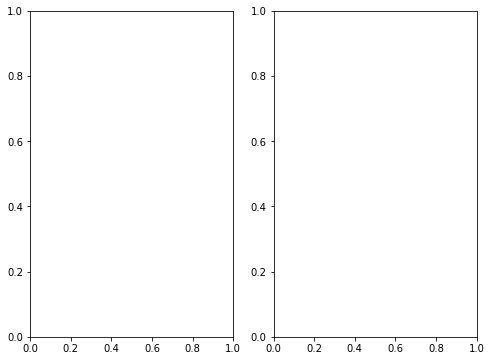

In [21]:
T_GD = 1000
eta_GD = .8
NLM_filter = .015			 		 

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_GD, time_per_iter_GD, psnr_per_iter_GD = PnP_GD_CSMRI(x_init, mask, y, eta_GD, T_GD, NLM_filter, patch_kw, ORIG)

# Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_GD), psnr_per_iter_GD)

psnr_ax[1].plot(range(np.cumsum(time_per_iter_GD).size), psnr_per_iter_GD)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax[0].legend(('PnP-SVRG'), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
psnr_ax[1].legend("PnP-SVRG", loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()

In [ ]:
## Display output of PnP-GD
psnr_output_GD = peak_signal_noise_ratio(ORIG, output_GD)
gd_fig = plt.figure()
ax = gd_fig.add_subplot(1, 1, 1)
gd_plot = plt.imshow(output_GD, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-GD, PSNR = {psnr_output_GD:0.2f}")
ax.axis('off')

$\begin{equation}
    \textbf{PnP-SGD}(\boldsymbol{x}_0, \eta, T): \\
    \text{for } t = 1, 2, . . ., T \text{ do} \\
    \hspace{2ex} \text{pick } i_t \in \{ 1, ..., m \} \text{ randomly} \\
	\hspace{2ex} \boldsymbol{x}_t = \boldsymbol{x}_{k-1} - \eta \nabla \ell_{i_t} (\boldsymbol{x}_{t-1}) \\
    \hspace{2ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_t) \\
    \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$

In [ ]:
def PnP_SGD_CSMRI(z, MASK, meas, eta, T, batch_size, FILTER, patch, orig):
    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask
    
    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t2 = 0
    
    # Main PnP SGD routine
    for i in range(T):
        start_iter = time.time()
        # Update variables
        ind = get_batch(batch_size, H, W, index)
        v = stoch_grad(z, MASK, meas, ind)
        z = z - eta * v

        # Denoising
        ztilde = np.copy(z)
        z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
        stop_iter = time.time()
        time_per_iter.append(stop_iter-start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        t2 += 1
    return z, time_per_iter, psnr_per_iter

In [ ]:
T_SGD = 1000
eta_SGD = .8				# step size for GD
batch_size_SGD = 1000
NLM_filter = .015			 		 

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_SGD, time_per_iter_SGD, psnr_per_iter_SGD = PnP_SGD_CSMRI(x_init, mask, y, eta_SGD, T_SGD, batch_size_SGD, \
                                                                 NLM_filter, patch_kw, ORIG)



In [ ]:
## Display output of PnP-SGD
psnr_output_SGD = peak_signal_noise_ratio(ORIG, output_SGD)
sgd_fig = plt.figure()
ax = sgd_fig.add_subplot(1, 1, 1)
sgd_plot = plt.imshow(output_SGD, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-SGD, PSNR = {psnr_output_SGD:0.2f}")
ax.axis('off')



(Need to rewrite code. originally taken from: https://github.com/uclaopt/Provable_Plug_and_Play and not working)

$\begin{equation}
    \textbf{PnP-ADMM}(\boldsymbol{x}_0, \boldsymbol{v}_0, \boldsymbol{u}_0, \eta, T): \\
    \text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{x}_t = \text{prox}_d (\boldsymbol{v}_{t-1} - \boldsymbol{u}_{t-1}; \eta) \\
	\hspace{2ex} \boldsymbol{v}_t = \text{denoise}_\sigma (\boldsymbol{x}_{t} + \boldsymbol{u}_{t-1}) \\
	\hspace{2ex} \boldsymbol{u}_{t} = \boldsymbol{u}_{t-1} + (\boldsymbol{x}_{t} - \boldsymbol{v}_t) \\
    \text{end}
\end{equation}$

$\text{prox}_g (\boldsymbol{z}; \eta) \overset{\Delta}{=} {\arg\min}_{\boldsymbol{x}} \left\{ g(\boldsymbol{x}) + \frac{1}{2 \eta} \| \boldsymbol{x} - \boldsymbol{z} \|_2^2 \right\}$

In [9]:
def PnP_ADMM(alpha_, T_ADMM_, NLM_filter_):
    alpha = alpha_
    T_ADMM = T_ADMM_
    NLM_filter = NLM_filter_

    x = np.copy(x_init)
    print("Initial PSNR = " + str(peak_signal_noise_ratio(ORIG, x)))
    t3 = 0

    patch_kw = dict(patch_size=5,      # 5x5 patches
                    patch_distance=6,  # 13x13 search area
                    multichannel=True)

    time_per_iter_ADMM = []
    psnr_per_iter_ADMM = []

    v = np.copy(x)
    u = np.zeros((H,W), dtype=np.float64)

    """ Main loop. """
    for i in range(T_ADMM):
        start_iter = time.time()
        xold = np.copy(x)
        vold = np.copy(v)
        uold = np.copy(u)
        """ Update variables. """

        vtilde = np.copy(x+u)
        vf = np.fft.fft2(vtilde)

        vf[index] = alpha* ((1 / 2) * vf[index] + y[index]) / (1.0 + alpha)
        v = np.real(np.fft.ifft2(vf))

        """ Denoising step. """

        xtilde = np.copy(2*v - xold - uold)
        mintmp = np.min(xtilde)
        maxtmp = np.max(xtilde)
        xtilde = (xtilde - mintmp) / (maxtmp - mintmp)
        
        print(str(i) + " " + str(peak_signal_noise_ratio(ORIG, xold)))
        
        # pytorch denoising model
        x = denoise_nl_means(np.real(xtilde), h=NLM_filter, fast_mode=True, **patch_kw)
    
        x = x * (maxtmp - mintmp) + mintmp
        
        """ Update variables. """
        u = uold + xold - v
        stop_iter = time.time()

        time_per_iter_ADMM.append(stop_iter-start_iter)
        psnr_per_iter_ADMM.append(peak_signal_noise_ratio(ORIG, x))
        print(str(i) + " " + str(peak_signal_noise_ratio(ORIG, x)))
        t3 += 1
    return x, time_per_iter_ADMM, psnr_per_iter_ADMM 

In [10]:
output_SVRG, time, psnroutput = PnP_ADMM(4, 20, 5)

## Display output of PnP-ADMM
psnr_output_ADMM = peak_signal_noise_ratio(ORIG, output_ADMM)
admm_fig = plt.figure()
ax = admm_fig.add_subplot(1, 1, 1)
admm_plot = plt.imshow(output_ADMM, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-ADMM, PSNR = {psnr_output_ADMM:0.2f}")
ax.axis('off')

Initial PSNR = 12.983582530165517
0 12.983582530165517
0 9.572137131748496
1 9.572137131748496
1 10.311977809521238
2 10.311977809521238
2 10.612010413545026
3 10.612010413545026
3 10.73172735441731
4 10.73172735441731
4 10.779121303828576
5 10.779121303828576
5 10.797712512538586


KeyboardInterrupt: 

In [ ]:
psnr_list = []
num_trials = 20
alpha_list = np.linspace(3.5, 4.5, num_trials)
for i in range(num_trials):
    output_SVRG, time, psnroutput = PnP_ADMM(alpha, T_ADMM, NLM_FILTER)
    psnr_list.append(psnroutput[-1])
    
admm_fig = plt.figure()
ax = admm_fig.add_subplot(1, 1, 1)
admm_plot = plt.plot(alpha_list, psnr_list)
ax.set_title(f"alpha vs. PSNR recovery")
ax.axis('on')
plt.show()

In [ ]:
## Display output of PnP-ADMM
psnr_output_ADMM = peak_signal_noise_ratio(ORIG, output_ADMM)
admm_fig = plt.figure()
ax = admm_fig.add_subplot(1, 1, 1)
admm_plot = plt.imshow(output_ADMM, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-ADMM, PSNR = {psnr_output_ADMM:0.2f}")
ax.axis('off')

$\begin{equation}
	\textbf{PnP-LSVRG}(\boldsymbol{x}_0, \eta, T, p): \\
    \text{Initialize } \boldsymbol{\tilde{x}} \\
	\text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{w} = \underbrace{\nabla d(\tilde{\boldsymbol{x}})}_{\text{full gradient}} \\
    \hspace{2ex} \text{pick } i_t \in \{ 1, ..., n \} \text{ randomly} \\
	\hspace{2ex} \boldsymbol{v}_t = \underbrace{\nabla d_{i_t} (\boldsymbol{x}_{t-1}) - \nabla d_{i_t} (\tilde{\boldsymbol{x}}) + \boldsymbol{w}}_{\text{stochastic variance-reduced gradient}} \\
	\hspace{2ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_{t-1} - \eta \boldsymbol{v}_t) \\
	\hspace{2ex} \text{Update} \hspace{1ex} \tilde{\boldsymbol{x}} = \boldsymbol{x}_t 
\hspace{2ex} \text{ w.p. } p \\ \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$

In [18]:
def PnP_LSVRG_CSMRI(z, MASK, meas, eta, T, batch_size, p, FILTER, patch, orig):
    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask
    
    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t4 = 0
    
    # Main PnP SVRG routine
    w = np.copy(z)
    for i in range(T):
        # outer loop
        mu = full_grad(w, MASK, meas)   	# Average gradient
        # 	w = np.copy(x) 					# reference point
        start_iter = time.time()

        # inner loop
        ind = get_batch(batch_size, MASK) 	# Get batch index(indices) in terms of (row, col)

        start_grad = time.time()
        v = stoch_grad(z, ind, meas) - stoch_grad(w, ind, meas) + mu
        z = z - eta*v

        # Denoising
        ztilde = np.copy(z)
        z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)

        # update reference point with probability 1-p
        if np.random.random() > p:
            w = np.copy(z)

        stop_iter = time.time()
        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        time_per_iter.append(stop_iter - start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        t4 += 1
    return z, time_per_iter, psnr_per_iter

In [19]:
T_LSVRG = 10 				# Number of outer loop iterations
eta_LSVRG = .08				# step size for SVRG
p_LSVRG = .2						# probability of NOT updating reference point
batch_size_LSVRG=30000
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_LSVRG, time_per_iter_LSVRG, psnr_per_iter_LSVRG = PnP_LSVRG_CSMRI(x_init, mask, y, eta_LSVRG, T_LSVRG, \
                                                                         batch_size_LSVRG, p_LSVRG, \
                                                                         NLM_filter, patch_kw, ORIG)

0 13.381646296443968
1 13.767222477668517
2 14.14064871804333
3 14.502263332802304
4 14.852522101179531
5 15.19250198873912
6 15.519435441981187
7 15.83537582378916
8 16.141839906099424
9 16.43076162299012


In [ ]:
## Display output of PnP-L-SVRG
psnr_output_LSVRG = peak_signal_noise_ratio(orig, output_LSVRG)
lsvrg_fig = plt.figure()
ax = lsvrg_fig.add_subplot(1, 1, 1)
lsvrg_plot = plt.imshow(output_LSVRG, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-L-SVRG, PSNR = {psnr_output_LSVRG:0.2f}")
ax.axis('off')

(not yet working, need to learn how to choose parameters)

$\begin{equation}
	\textbf{PnP-LKatyusha}(\theta_1, \theta_2, p \in (0, 1], T): \\
    \text{Initialize } \boldsymbol{y}_0 = \boldsymbol{w}_0 = \boldsymbol{z}_0 \in \mathbb{R}^n, \text{ stepsize } \eta = \frac{\theta_2}{(1 + \theta_2) \theta_1} \text{ and set } \sigma = \frac{\mu}{L}\\
	\text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{x}_t = \theta_1 \boldsymbol{z}_t + \theta_2 \boldsymbol{w}_t + (1 - \theta_1 - \theta_2) \boldsymbol{y}_k \\
    \hspace{2ex} \text{pick } i_t \in \{ 1, ..., n \} \text{ randomly} \\
	\hspace{2ex} \boldsymbol{g}_t = \nabla \ell_i (\boldsymbol{x}_t) - \nabla_i \ell_i (\boldsymbol{w}_t) + \nabla \ell (\boldsymbol{w}_t) \\
	\hspace{2ex} \boldsymbol{z}_{t+1} = \frac{1}{1 + \eta \sigma} (\eta \sigma \boldsymbol{x}_t + \boldsymbol{z}_t - \frac{\eta}{L} \boldsymbol{g}_t) \\
    \hspace{2ex} \boldsymbol{y}_{t+1} = \boldsymbol{x} + \theta_1 (\boldsymbol{z}_{t+1} - \boldsymbol{z}_t) \\
	\hspace{2ex} \text{Update} \hspace{1ex} \boldsymbol{w}_{t+1} = \boldsymbol{y}_t
\hspace{2ex} \text{ w.p. } p \\ \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$

In [ ]:
T_LKatyusha = 10 				# Number of outer loop iterations

p = .2						# probability of NOT updating reference point
theta1 = .1
theta2 = .1
eta_LKatyusha = theta2/((1+theta2)*theta1)				# step size for SVRG
mu = 1
L = 1
sigma = mu/L

batch_size_LKatyusha=30000
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

time_per_iter_LKatyusha = []
psnr_per_iter_LKatyusha = []

y = np.copy(x_init)
w = np.copy(x_init)
z = np.copy(x_init)

t5 = 0
# Main PnP SVRG routine
for i in range(T_LKatyusha):
    z_old = np.copy(z)
    x = theta1*z + theta2*w + (1 - theta1 - theta2)*y
    start_iter = time.time()

    # inner loop
    ind = get_batch(batch_size_LKatyusha, H, W, index) 	# Get batch index(indices) in terms of (row, col)

    start_grad = time.time()
    g = stoch_grad(x, mask, y, ind) - stoch_grad(w, mask, y, ind) + full_grad(w, mask, y)
    z = (1 / (1 + eta_LKatyusha*sigma))*(eta_LKatyusha*sigma*x + z - eta_LKatyusha / L * g)
    y = x + theta1*(z - z_old)
    
    # Denoising
    wtilde = np.copy(w)

    # denoise
    w = denoise_nl_means(np.real(wtilde), h=NLM_filter, fast_mode=True, **patch_kw)
    print(str(i) + " " + str(peak_signal_noise_ratio(orig, w)))

    # update reference point with probability 1-p
    if np.random.random() > p:
        w = np.copy(y)
        
    stop_iter = time.time()
    time_per_iter_LKatyusha.append(stop_iter - start_iter)
    psnr_per_iter_LKatyusha.append(peak_signal_noise_ratio(orig, w))

    t5 += 1
output_LKatyusha = w

In [ ]:
## Display output of PnP-L-Katyusha
psnr_output_LKatyusha = peak_signal_noise_ratio(orig, output_LKatyusha)
lkatyusha_fig = plt.figure()
ax = lkatyusha_fig.add_subplot(1, 1, 1)
lkatyusha_plot = plt.imshow(output_LKatyusha, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-L-Katyusha, PSNR = {psnr_output_LKatyusha:0.2f}")
ax.axis('off')

In [ ]:
# Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_SVRG), psnr_per_iter_SVRG)
psnr_ax[0].plot(np.cumsum(time_per_iter_GD), psnr_per_iter_GD)
psnr_ax[0].plot(np.cumsum(time_per_iter_SGD), psnr_per_iter_SGD)
psnr_ax[0].plot(np.cumsum(time_per_iter_ADMM), psnr_per_iter_ADMM)
psnr_ax[0].plot(np.cumsum(time_per_iter_LSVRG), psnr_per_iter_LSVRG)
psnr_ax[0].plot(np.cumsum(time_per_iter_LKatyusha), psnr_per_iter_LKatyusha)

psnr_ax[1].plot(range(t0), psnr_per_iter_SVRG)
psnr_ax[1].plot(range(t1), psnr_per_iter_GD)
psnr_ax[1].plot(range(t2), psnr_per_iter_SGD)
psnr_ax[1].plot(range(t3), psnr_per_iter_ADMM)
psnr_ax[1].plot(range(t4), psnr_per_iter_LSVRG)
psnr_ax[1].plot(range(t5), psnr_per_iter_LKatyusha)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
# psnr_ax[0].legend(('PnP-SVRG', 'PnP-GD', 'PnP-SGD', 'PnP-ADMM', 'PnP-LSVRG', 'PnP-LKatyusha'), loc='lower right')
psnr_ax[0].legend(('PnP-SVRG', 'PnP-GD'), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
# psnr_ax[1].legend(('PnP-SVRG','PnP-GD', 'PnP-SGD', 'PnP-ADMM', 'PnP-LSVRG', 'PnP-LKatyusha'), loc='lower right')
psnr_ax[1].legend(('PnP-SVRG','PnP-GD'), loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()